# Introduction

Continual learning for semantic segmentation is a field that has emerged recently and is quickly evolving. As a newcomer to the field, I wanted to quickly get in touched with the popular approaches and see by myself some concrete results. However, if one wants to rerun the experiments made in recent papers, which often use medium- to large-scale datasets such as Pascal-VOC, ADE20K or COCO, it would require several hours of training. 

Therefore, I took inspiration from the [Simple Deep Learning project](https://https://awaywithideas.com/mnist-extended-a-dataset-for-semantic-segmentation-and-object-detection/) by Luke Tonin in which he built MNIST-Extended, a semantic segmentation dataset  made from MNIST. While this is obviously a toy dataset, it has the benefit of giving quick feedback while tinkering with models. 

I adapted it to the class-incremental scenario such that the segmentation masks are only available for the current classes. Learning the 0-9 digits is therefore performed in successive tasks. In this tutorial, we explore a scenario in which there are 2 new classes to learn at each task: (0, 1), (2, 3), (4, 5), (6, 7), (8, 9). 

This will also enable to explore common challenges of continual semantic segmentation such as Catastrophic forgetting, background shift, and the various combinations of setups where past/future classes are/are not in images and labeled as background. 

# TODO
1. 

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [1]:
# some initial imports
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import os
import sys
from tqdm import tqdm
import pandas as pd

os.chdir("/content/gdrive/MyDrive/Colab Notebooks/mnist_continual_seg")
sys.path.append("/content/gdrive/MyDrive/Colab Notebooks/simple_deep_learning")

Now that the segmentation dataset is loaded, we need to adapt it to reflect the continual setup where classes are seen sequentially. To do so, we will implement a processing function that only keeps the groundtruth masks for the current learning step. For instance, if we divide the 10 classes from MNIST in 5 learning steps of 2 classes, then at step #0 the model is only trained to segment digits 0 and 1, while other digits on the image are labeled as background (i.e. label '0'). Then, at step #1 where the model must learn to segment 2's and 3's, digits 0-1 and 4-9 will be labeled as background, and so on.

This scenario reflects the common experimental setup in which segmentation masks are only available for current classes while objects that belong to past and future classes can still appear in scene images (e.g. from Pascal-VOC) but are labeled as background. This is a challenge specific to Continual Semantic Segmentation known as Background shift, which is addressed in several recent works (MiB, PLOP, SSUL, RECALL, etc). 

In [2]:
from trainer import Trainer, Trainer_MIB, Trainer_distillation
from metrics import EvaluaterCallback
from scenarios import ContinualMnist
from models import simple_seg_model
from utils import meta_train
_tasks = {0: [0,1], 1: [2,3], 2: [4,5], 3: [6,7], 4: [8,9]}

In [3]:
from models.backbones import simple_backbone
from models.modules import self_attention_cam

In [4]:
class PseudoSeg(simple_seg_model):
  def __init__(self,
               conv_filters=32,
               n_classes_per_task=[2],
               input_shape=(1, 60,60),
               attention_dim=64):

    super(PseudoSeg, self).__init__(conv_filters,
                                    n_classes_per_task,
                                    input_shape)
    
    self.cam1 = nn.Sequential(nn.Conv2d(conv_filters , conv_filters, kernel_size=1, bias=False),
                             nn.BatchNorm2d(conv_filters),
                             nn.ReLU())
    
    self.avg_pool = nn.AdaptiveAvgPool2d(1)
    self.classif = nn.Conv2d(self.conv_filters, sum(n_classes_per_task), 1) 
    self.sa = self_attention_cam(num_class=sum(n_classes_per_task),
                                 in_dim=conv_filters*2,
                                 attention_dim=attention_dim,
                                 linformer=False,
                                 factor=2)
    self.conv_sgc = nn.Conv2d(sum(n_classes_per_task), sum(n_classes_per_task), 1)

  def forward(self, x):
    x_block2, x_block3 = self.encoder(x, return_blocks=True)
    hypercolumn = torch.cat([x_block2, x_block3], dim=1)
    x_dec = self.decoder(x_block3)

    cam, y_labs = self._classification_head(x_block3)
    y_seg = self._segmentation_head(x_dec)

    return [hypercolumn, cam], y_labs, y_seg#, self_attn

  def self_attention(self, logits, features):
    x = self.sa(logits, features)
    x = F.interpolate(x, (60, 60), mode="bilinear", align_corners=True)
    x = self.conv_sgc(x)
    return x

    
  def _classification_head(self, x):
    cam1 = self.cam1(x)
    avg = self.avg_pool(cam1)
    
    cls = self.classif(avg).squeeze(-1).squeeze(-1)
    return cam1, cls

  def _segmentation_head(self, x):
    x_o = self.cls(x)
    return x_o


In [5]:
def compute_cross_matrix(a, b):
  batch_size, d, h, w = a.shape
  a = a.reshape(batch_size, d, h*w)
  b = b.reshape(batch_size, d, h*w)
  cross_corr = torch.matmul(a.permute(0,2,1), b)
  return cross_corr

class cross_correlation(nn.Module):
  def __init__(self):
    super().__init__()

  def forward(self, a, b, y_true):
    # a.shape = (b, d, h, w)
    # b.shape = (b, d, h, w)
    batch_size, d, h, w = a.shape
    a = F.normalize(a, dim=1)
    b = F.normalize(b, dim=1)

    cross_corr = compute_cross_matrix(a, b)
    loss = torch.mean((y_true - cross_corr)**2)
    return loss

c = cross_correlation()
c(torch.zeros((1,10, 60, 60)), torch.zeros((1,10, 60, 60)), torch.eye(60*60).unsqueeze(0))

tensor(0.0003)

In [6]:
class Trainer_MIB_crosscorrelation(Trainer_MIB):
  def __init__(self,
               model,
               n_classes,
               optim,
               from_new_class,
               old_model=None,
               lambda_distill=0,
               output_level_distill=False,
               encoder_level_distill=False,
               decoder_level_distill=False,
               curr_task=0,
               callbacks=[],
               **kwargs):
    super(Trainer_MIB_crosscorrelation, self).__init__(
                                                        model,
                                                        n_classes,
                                                        optim,
                                                        from_new_class,
                                                        old_model,
                                                        lambda_distill,
                                                        output_level_distill,
                                                        encoder_level_distill,
                                                        decoder_level_distill,
                                                        curr_task,
                                                        callbacks,
                                                        **kwargs)
    self.cross_correlation_criterion = cross_correlation()

  def _train_step(self, images, labels):
    if self.old_model is not None and self.lambda_distill != 0:
      return self._train_step_distillation(images, labels)
    else:
      return super()._train_step(images, labels)
  
  def _train_step_distillation(self, images, labels):
    assert self.old_model is not None
    
    self.optim.zero_grad()
    
    new_enc, new_dec, new_outputs = self.model(images, return_intermediate=True)
    old_enc, old_dec, old_outputs = self.old_model(images, return_intermediate=True)
    
    ce_loss = self._compute_loss(new_outputs, labels)
    d_loss = self._distillation_loss(new_enc,
                                    old_enc,
                                    new_dec,
                                    old_dec,
                                    new_outputs,
                                    old_outputs,
                                    labels)
    
    labels_one_hot = F.one_hot(labels, num_classes = sum(self.n_classes_per_task)).permute(0,3,1,2).float()
    labels_matrix = compute_cross_matrix(labels_one_hot, labels_one_hot)
    cc_loss = self.cross_correlation_criterion(new_outputs, new_outputs, labels_matrix)

    loss = ce_loss + self.lambda_distill * d_loss + cc_loss
    loss.backward()
    self.optim.step()
    
    return ce_loss


In [ ]:
from trainer import Trainer_PseudoLabel_ImageLabels
# Initialize dataloader, optimizer and trainer
model = simple_seg_model(n_classes_per_task=[len(_tasks[0])+1], conv_filters=64)
model = model.cuda()
optimizer = torch.optim.Adam(lr = 0.0005, params=model.parameters())

continual_mnist = ContinualMnist(n_train=1000, n_test=1000, batch_size=32, tasks=_tasks, return_im_level_label=False)

evaluater = EvaluaterCallback(model, ["confusion_matrix"], callback_frequency="task", n_classes=11, save_matrices=True, out_idx=None)

trainer = Trainer_MIB_crosscorrelation(model,
                  n_classes=[3],
                  optim=optimizer,
                  from_new_class = 0,
                  callbacks=[evaluater],
                  output_level_distill=True,
                  lambda_distill=1,
                  show_preds=False)

meta_train(n_tasks = len(_tasks),
           epochs = 200,
           scenario = continual_mnist, 
           trainer=trainer,
           evaluater=evaluater,
           animation_path="nothing_yet",
           pass_first_step = False)

*******
Task #0
*******
Classes to learn:
-1 0 1
*******


In [ ]:
import copy
from loss import UnbiasedKnowledgeDistillationLoss, UnbiasedCrossEntropy
def _div_maybe_zero(total_loss, num_present):
  """Normalizes the total loss with the number of present pixels."""
  return (num_present > 0).float() * total_loss/torch.max(num_present, torch.ones_like(num_present)*1e-5)

def compute_cam(features, logits, num_class, image_labels):
  conv_layer = features
  cams = []
  for c in range(num_class-1):
    grads = torch.autograd.grad(torch.sum(logits[:, c+1]), conv_layer, retain_graph=True)
    weights = torch.mean(grads[0], axis=(2,3), keepdim=True)
    weighted_grads = weights * conv_layer
    curr_cams = F.relu(torch.sum(weighted_grads, axis=1))
    cams.append(curr_cams)
  cams = torch.stack(cams, axis=1)

  # image-level annotation
  cls_label = torch.reshape(image_labels[:,1:num_class], [-1, num_class - 1, 1, 1])
  cams = cls_label * cams

  # Normalize to [0, 1])
  cams = _div_maybe_zero(cams, torch.amax(cams, dim=(2,3), keepdim=True))

  #stop gradient
  out_cam = cams.detach().clone()

  return out_cam

class Trainer_PseudoSeg(Trainer):
  def __init__(self,
               model,
               n_classes,
               optim,
               curr_task=0,
               callbacks=[],
               show_preds = False,
               **kwargs):
    super(Trainer_PseudoSeg, self).__init__(model,
                                            n_classes,
                                            optim,
                                            curr_task,
                                            callbacks,
                                            **kwargs)
    self.show_preds = show_preds
    self.old_model = None
    self.test_mib = True
    self.from_new_class = 0
  def train(self, 
            cur_epoch,
            scenario,
            memory=None,
            sample_memory=False):
    """Train for 1 epoch."""
    epoch_loss = 0
    num_classes = sum(self.n_classes_per_task)

    self.show_preds = cur_epoch > 496
    for cur_step, (images, labels, image_labels) in enumerate(scenario.train_stream):      
      if self.show_preds:
        plt.imshow(images[0].detach().cpu().numpy()[0])
        plt.show()
      images, labels, image_labels = images.cuda().float(), labels.cuda().long(), image_labels[:, :num_classes].cuda()
      epoch_loss += self._train_step(images, labels, image_labels)
      self._apply_callbacks(scenario, freq="step")
    self._apply_callbacks(scenario, freq="epoch")
    return epoch_loss / len(scenario.train_stream)


  def sharpen(self, p, m, T):
    def _norm(a, b):
      return torch.linalg.norm(a+b, dim=1, keepdim=True)
    norm = _norm(p, m)
    p_hat = F.softmax(p/norm, dim=1)
    m_hat = F.softmax(m/norm, dim=1)

    x = 0.5 * p_hat + 0.5 * m_hat#, dim=1)

    x = x**(1/T)/torch.sum(x**(1/T), dim=1, keepdim=True)
    
    return x

  def _train_step(self, images, labels, image_labels):
    """Perform 1 training iteration."""
    num_classes = sum(self.n_classes_per_task)
    self.optim.zero_grad()
    features, y_labs, y_seg = self.model(images)

    att_logits_weak, y_hat_semi = self._self_attention_branch(features, y_labs, labels, image_labels)
    if self.old_model is not None:
      old_features, old_y_labs, old_y_seg = self.old_model(images)
      old_att_logits_weak, old_y_hat_semi = self._self_attention_branch(old_features, old_y_labs, labels, image_labels, old_model=True)

      plt.imshow(np.argmax(old_y_seg.detach().cpu().numpy()[0], axis=0))
      plt.show()
      plt.imshow(np.argmax(old_att_logits_weak.detach().cpu().numpy()[0], axis=0))
      plt.show()

      if self.test_mib:
        ukd_loss = UnbiasedKnowledgeDistillationLoss()
        distill_loss = ukd_loss(y_seg, old_y_seg.detach().clone())
        distill_selfattn_loss = ukd_loss(att_logits_weak, old_att_logits_weak.detach().clone())
      else:
        pseudo_label = F.softmax(old_y_seg+old_att_logits_weak, dim=1)# + F.softmax(old_att_logits_weak, dim=1)#self.sharpen(old_y_seg, old_y_seg, 0.5)
        
        pseudo_label *= torch.ones_like(pseudo_label) * (torch.amax(pseudo_label, dim=1, keepdim=True)>0.75).int()
        pseudo_label *= (torch.ones_like(labels) * (labels==0).int()).unsqueeze(1)
        
        labels_one_hot = F.one_hot(labels, num_classes = sum(self.n_classes_per_task)).permute(0,3,1,2).float()
        pseudo_label = torch.cat([pseudo_label, labels_one_hot[:, -2:]], dim=1)
        pseudo_label = pseudo_label.detach().clone()

        pseudo_label = torch.max(pseudo_label, dim=1)[1]
      if self.show_preds:
        print(np.where(F.sigmoid(y_labs)[0].detach().cpu().numpy()>0.5)[0]-1)
        plt.imshow(images[0][0].detach().cpu().numpy())
        plt.show()
        plt.imshow(np.argmax(old_y_seg[0].detach().cpu().numpy(), axis=0))
        plt.show()
        plt.imshow(np.argmax(old_att_logits_weak[0].detach().cpu().numpy(), axis=0))
        plt.show()
        plt.imshow(np.argmax(y_seg[0].detach().cpu().numpy(), axis=0))
        plt.show()

    #else:
    #  pseudo_label = labels

    #TODO un_loss = self._compute_un_loss(images)
    classif_loss = self._compute_classif_loss(y_labs[:,1:num_classes], image_labels.float()[:,1:num_classes])
    seg_loss = self._compute_seg_loss(y_seg, labels) 
    attn_loss = self._compute_seg_loss(att_logits_weak, labels)
    loss = seg_loss + classif_loss + attn_loss
    if self.old_model is not None:
      loss += distill_loss
      #loss += distill_selfattn_loss

    loss.backward()

    self.optim.step()
    return loss

  def _compute_loss(self, outputs, labels):
    if self.old_model is not None:
      un_ce = UnbiasedCrossEntropy(old_cl=self.from_new_class+1)
      return un_ce(outputs, labels)
    else:
      return super(Trainer_PseudoSeg, self)._compute_loss(outputs, labels)

  def _self_attention_branch(self, features, logits, labels, image_labels, old_model = False):
    activation_map = self._compute_activation_map(features[1], logits, labels, image_labels)
    att_logits_weak = self._compute_att_logits(activation_map.detach().clone(), features[0].detach().clone(), labels, old_model=old_model)
    #att_prob_weak = F.softmax(att_logits_weak, dim=1)

    # Add bg score
    #bg = 1 - torch.max(activation_map, dim=1, keepdims=True)[0]
    #activation_map = torch.cat([bg, activation_map], dim=1)

    return att_logits_weak, _

  def _compute_activation_map(self, features, logits, labels, image_labels):
    return compute_cam(features, logits, logits.shape[1], image_labels)

  def _compute_att_logits(self, activation_map, features, labels, old_model=False):
    model = self.old_model if old_model else self.model
    if old_model:
      with torch.no_grad():
        att_logits_weak = model.self_attention(activation_map, features)
    else:
      att_logits_weak = model.self_attention(activation_map, features)
    #att_logits_weak = F.interpolate(out_att_cam, labels.shape[1:], mode="bilinear", align_corners=True)
    #att_logits_weak = 
    return att_logits_weak

  def _compute_seg_loss(self, y_pred, labels):
    #if len(labels.shape) == 3:
    #  labels = F.one_hot(labels, num_classes = sum(self.n_classes_per_task)).permute(0,3,1,2).float()
    return self._compute_loss(y_pred, labels)#self._softXEnt(y_pred, labels)
  
  def _softXEnt (self, input, target):
    logprobs = torch.nn.functional.log_softmax (input, dim = 1)#
    return  -(target * logprobs).sum() / (input.shape[0] * input.shape[2] * input.shape[3])

  def _compute_classif_loss(self, y_pred, y_true):
    #print(y_pred, y_true)
    return nn.BCEWithLogitsLoss()(y_pred, y_true)

  def _compute_un_loss(self, images, labels):
    pass

  def next_task(self, n_classes_per_task):
    """Switch to next task."""
    self.from_new_class += n_classes_per_task[-1]
    self.n_classes_per_task = n_classes_per_task
    
    self.old_model = copy.deepcopy(self.model)
    new_model = self._load_new_model(self.n_classes_per_task)
    self.model = new_model.cuda()
    self.curr_task += 1

*******
Task #0
*******
Classes to learn:
-1 0 1
*******


100%|██████████| 200/200 [01:11<00:00,  2.81it/s]



Overall stats
|    |   Overall Acc |   Mean Acc |   Mean IoU |
|---:|--------------:|-----------:|-----------:|
|  0 |      0.989421 |   0.908767 |   0.862278 |
Class IoU
|    |       -1 |        0 |        1 | 2   | 3   | 4   | 5   | 6   | 7   | 8   | 9   |
|---:|---------:|---------:|---------:|:----|:----|:----|:----|:----|:----|:----|:----|
|  0 | 0.989019 | 0.807115 | 0.790699 | X   | X   | X   | X   | X   | X   | X   | X   |
Class Acc
|    |       -1 |        0 |        1 | 2   | 3   | 4   | 5   | 6   | 7   | 8   | 9   |
|---:|---------:|---------:|---------:|:----|:----|:----|:----|:----|:----|:----|:----|
|  0 | 0.995688 | 0.876955 | 0.853659 | X   | X   | X   | X   | X   | X   | X   | X   |

####################################
Next Task
####################################
*******
Task #1
*******
Classes to learn:
-1 2 3
*******


  0%|          | 0/200 [00:00<?, ?it/s]

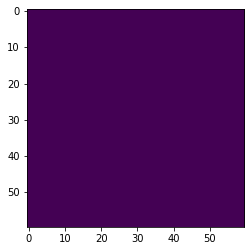

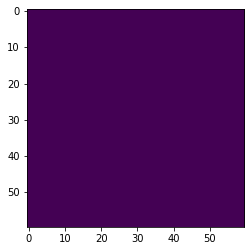

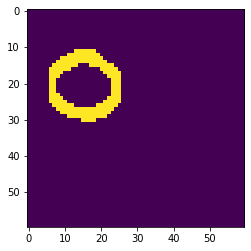

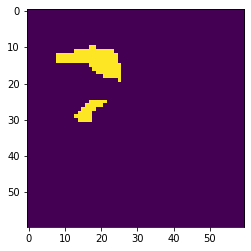

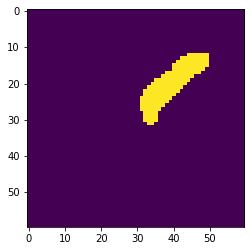

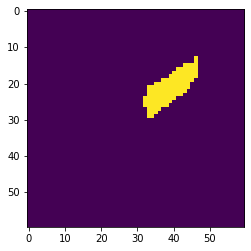

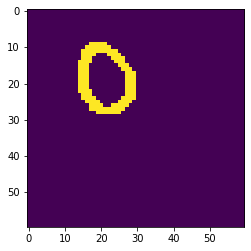

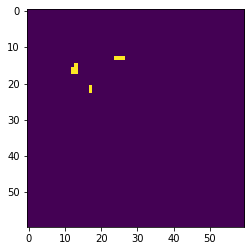

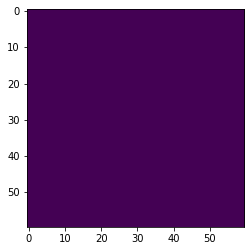

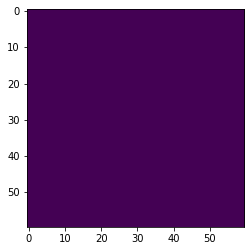

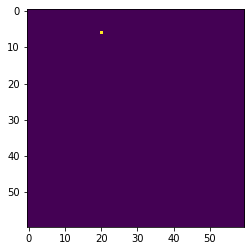

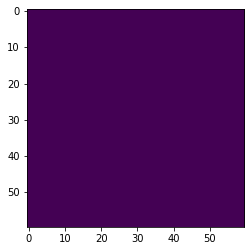

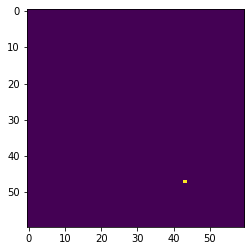

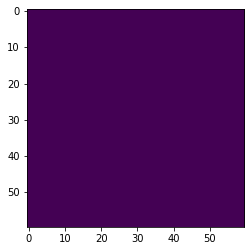

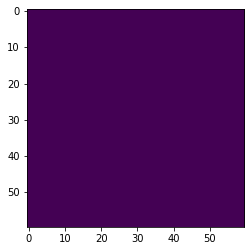

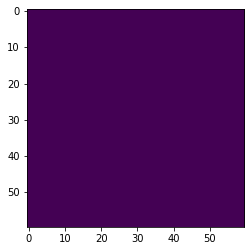

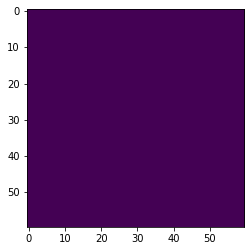

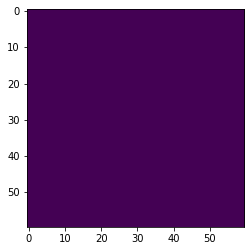

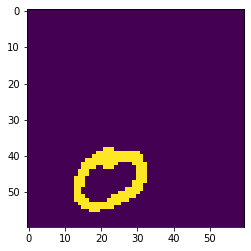

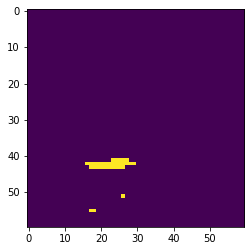

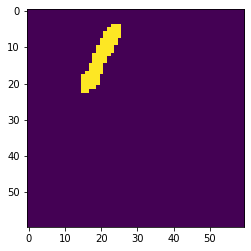

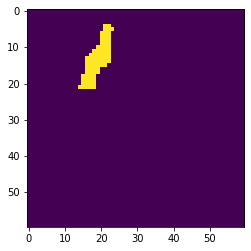

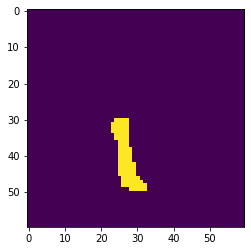

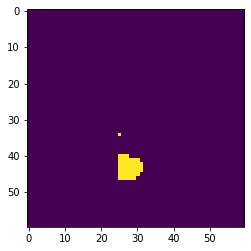

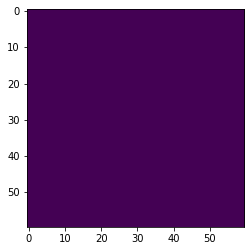

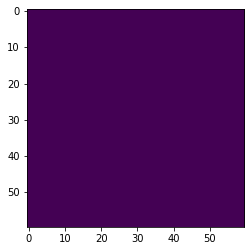

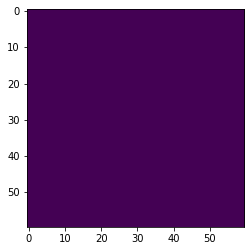

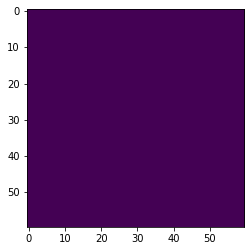

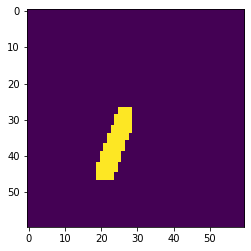

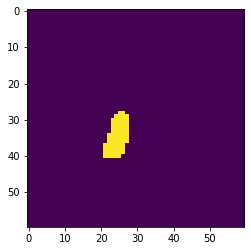

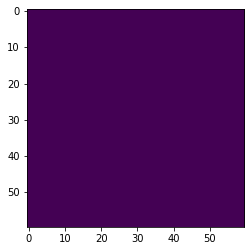

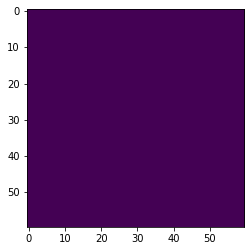

  0%|          | 1/200 [00:04<14:28,  4.36s/it]

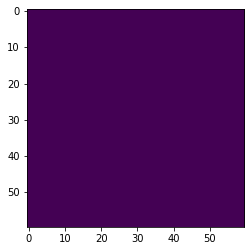

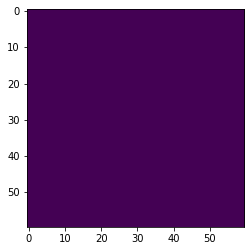

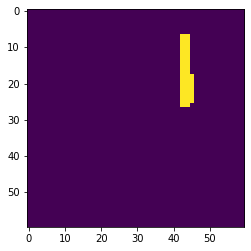

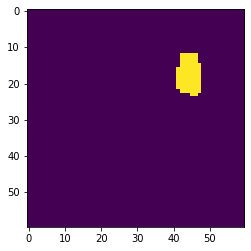

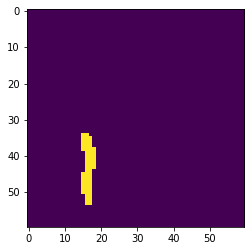

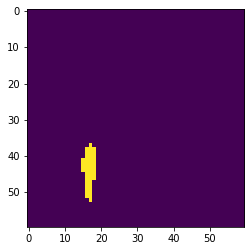

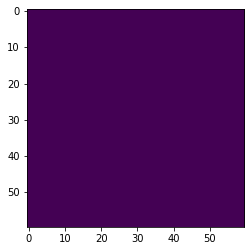

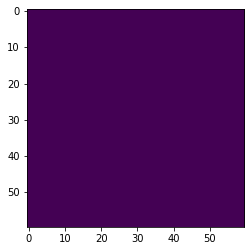

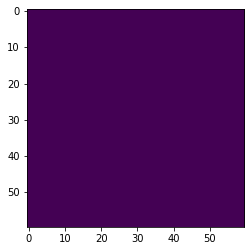

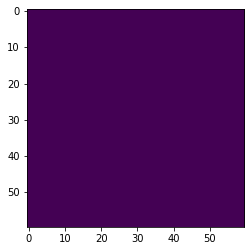

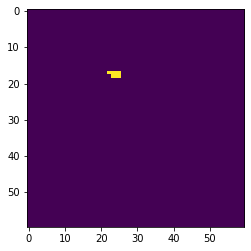

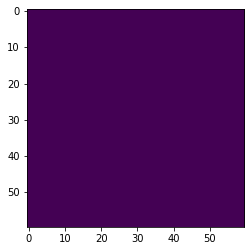

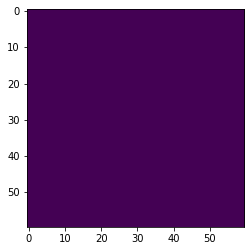

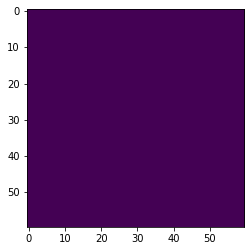

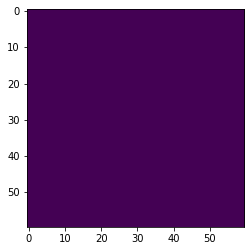

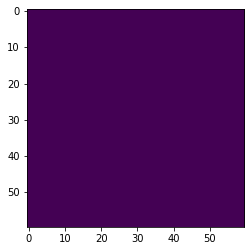

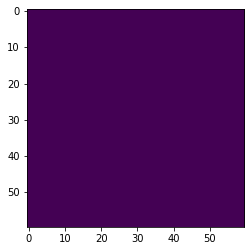

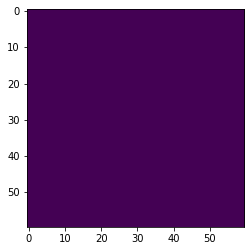

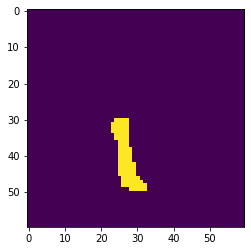

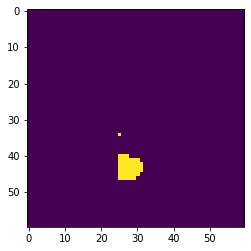

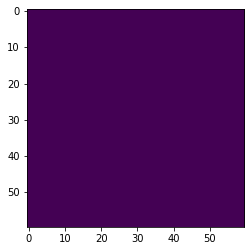

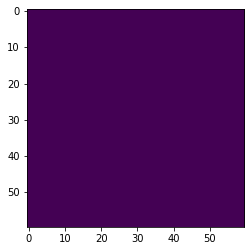

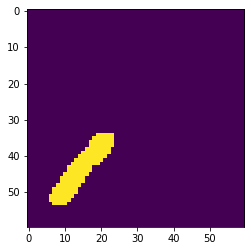

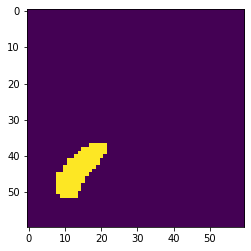

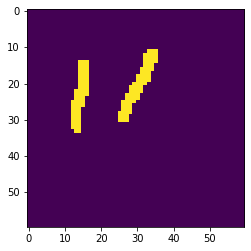

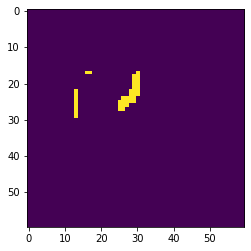

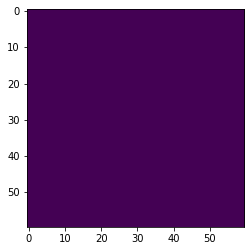

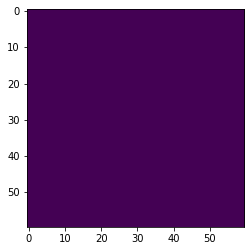

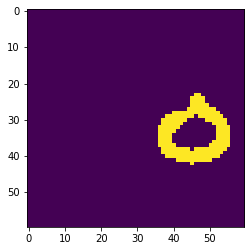

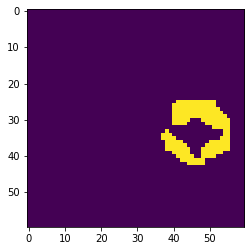

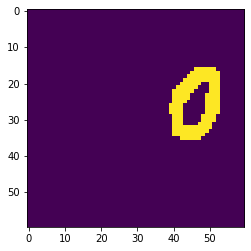

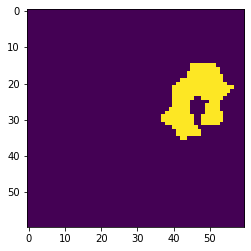

  1%|          | 2/200 [00:08<14:18,  4.34s/it]

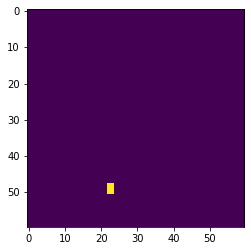

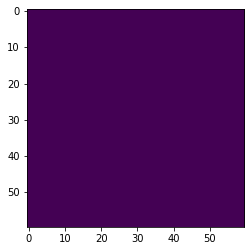

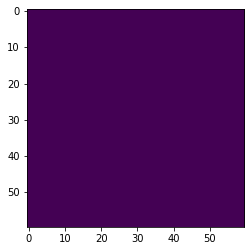

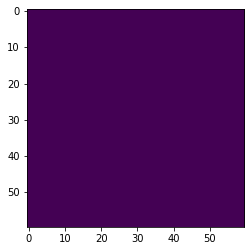

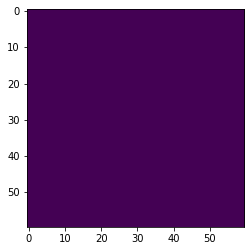

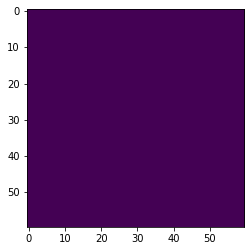

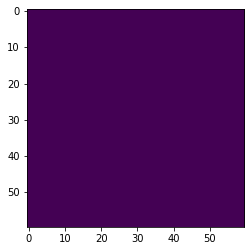

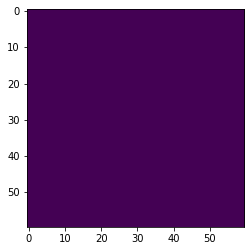

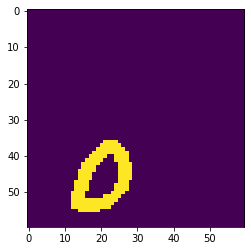

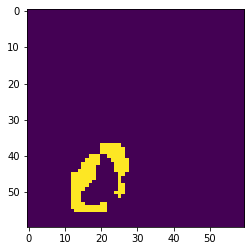

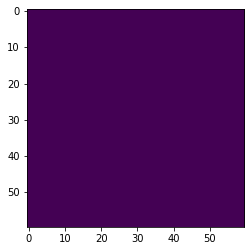

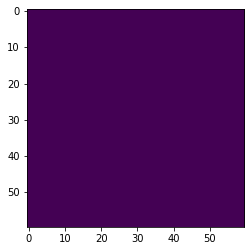

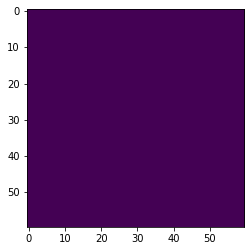

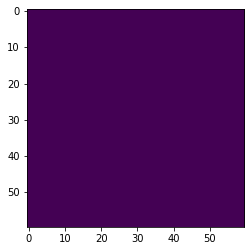

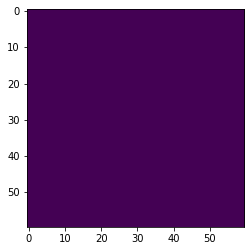

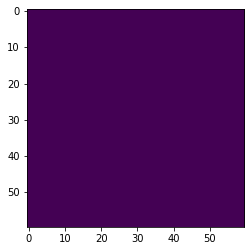

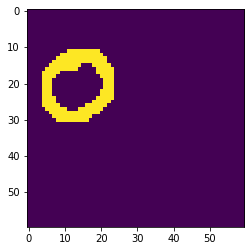

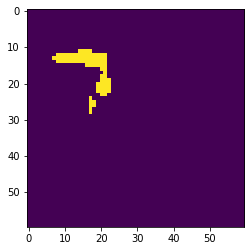

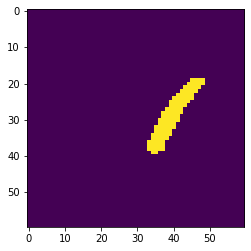

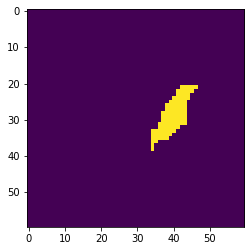

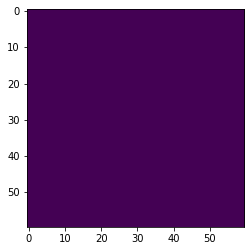

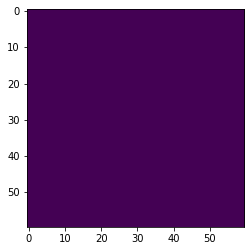

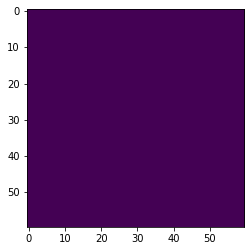

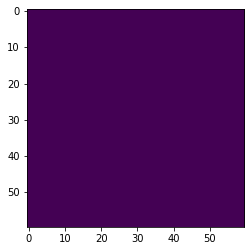

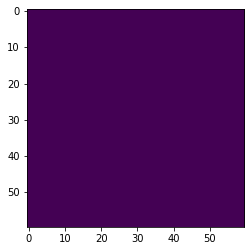

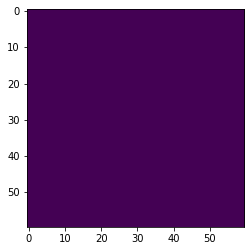

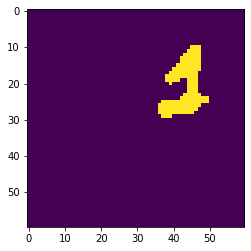

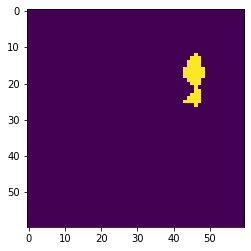

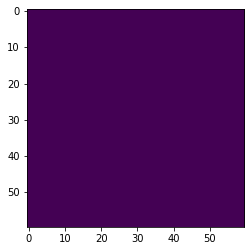

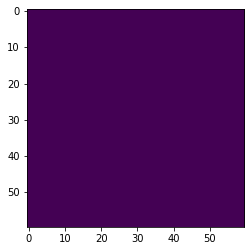

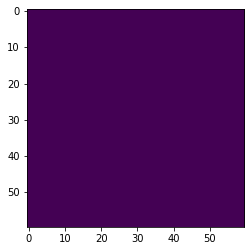

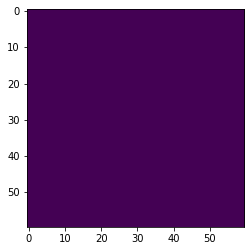

  2%|▏         | 3/200 [00:13<14:16,  4.35s/it]

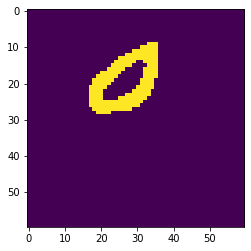

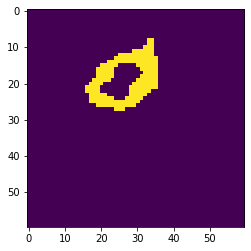

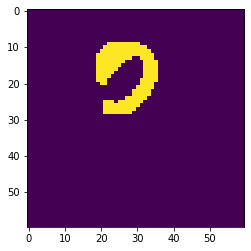

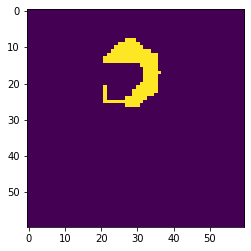

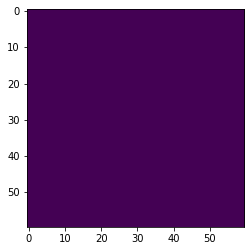

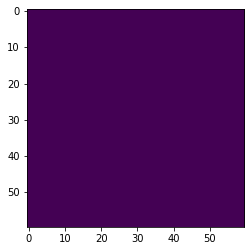

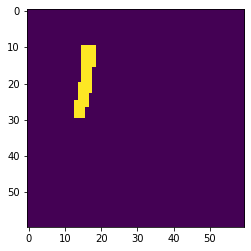

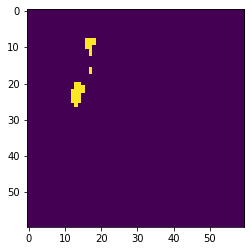

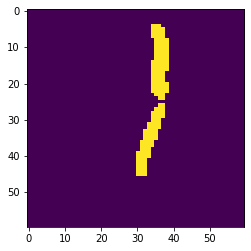

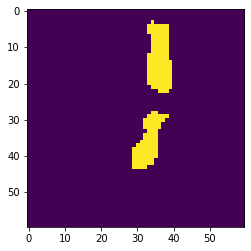

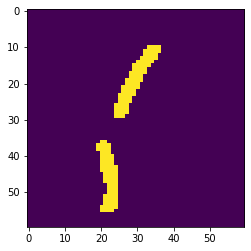

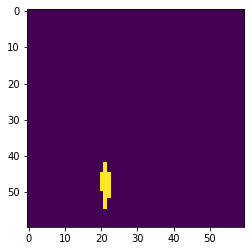

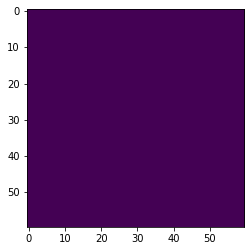

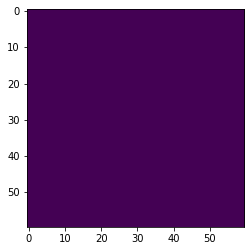

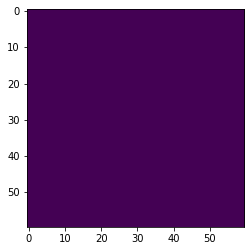

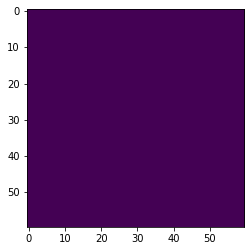

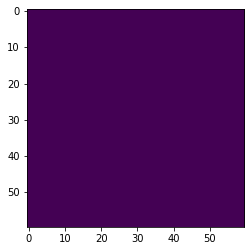

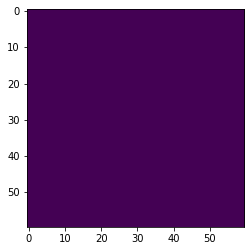

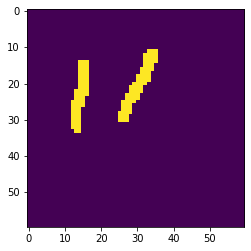

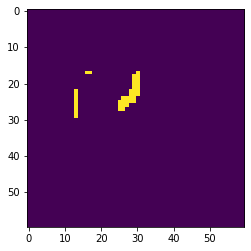

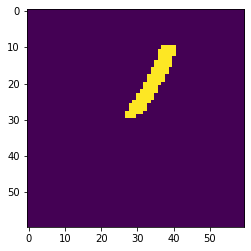

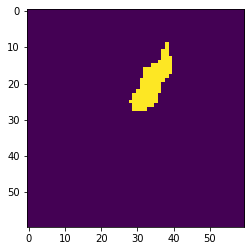

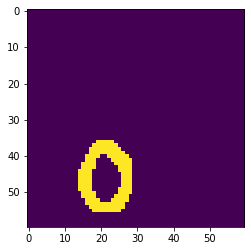

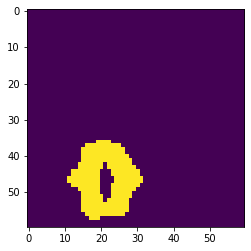

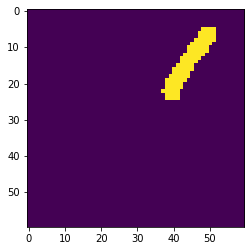

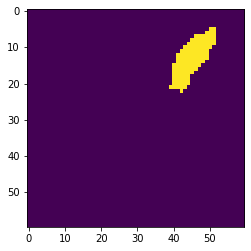

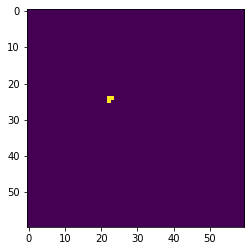

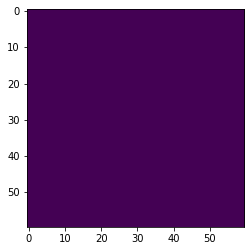

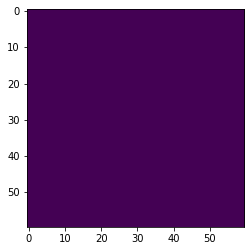

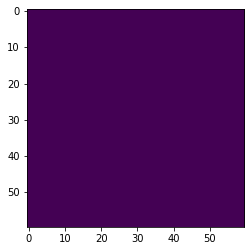

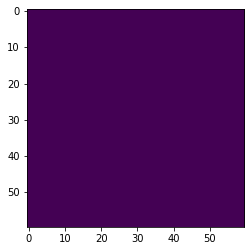

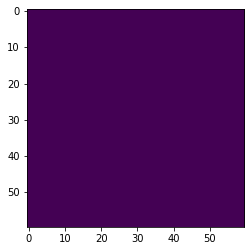

  2%|▏         | 4/200 [00:17<14:16,  4.37s/it]

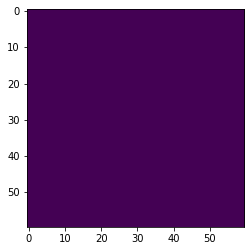

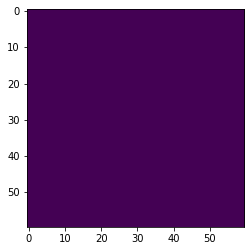

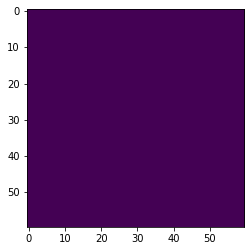

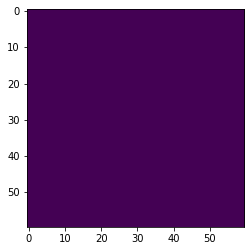

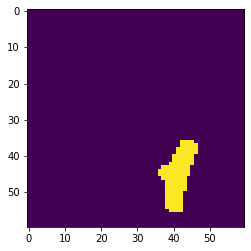

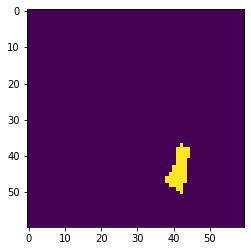

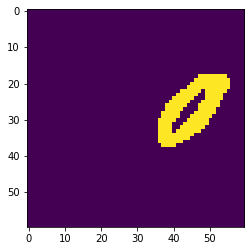

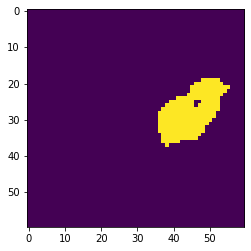

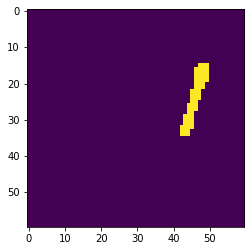

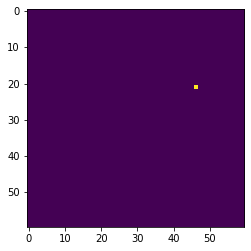

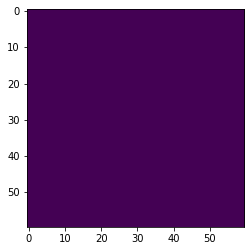

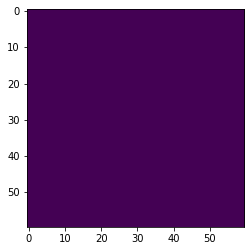

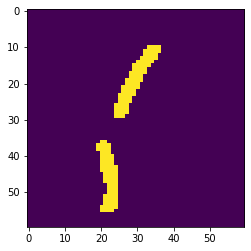

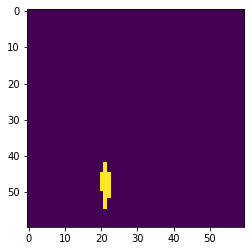

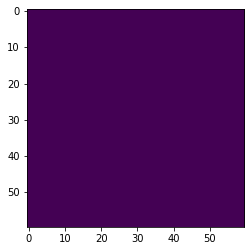

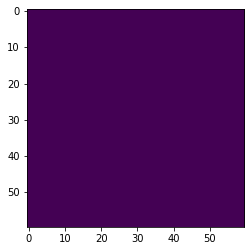

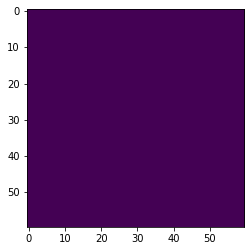

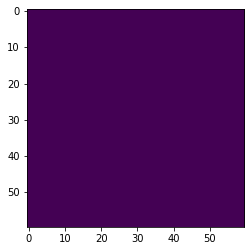

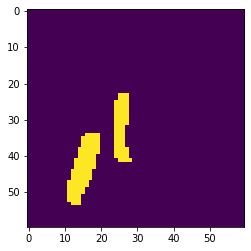

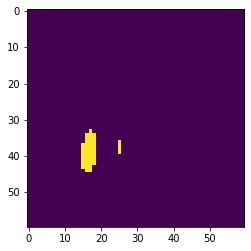

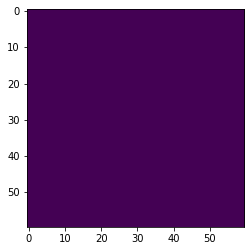

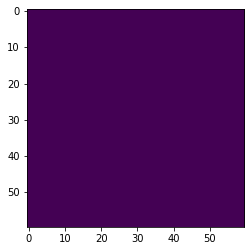

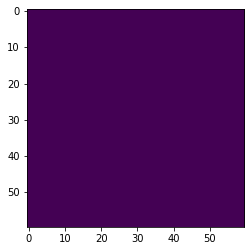

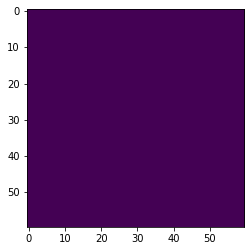

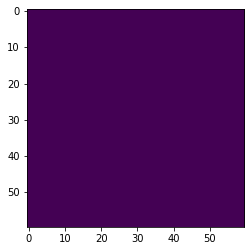

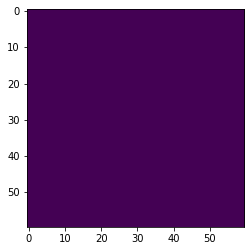

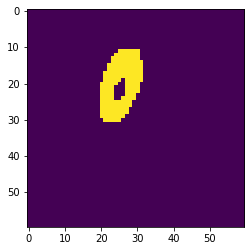

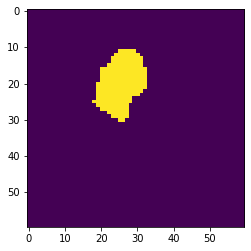

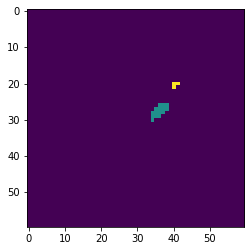

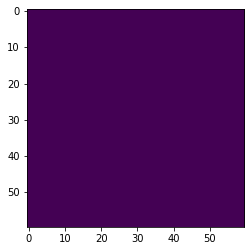

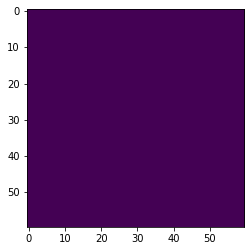

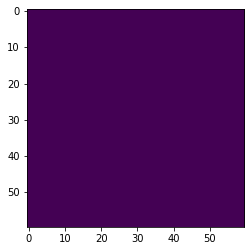

  2%|▎         | 5/200 [00:21<14:18,  4.40s/it]

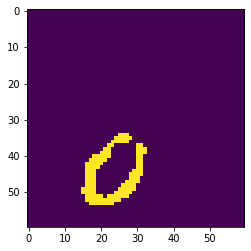

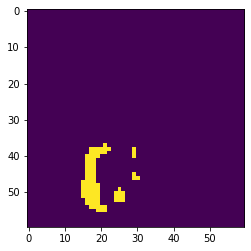

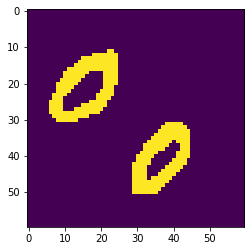

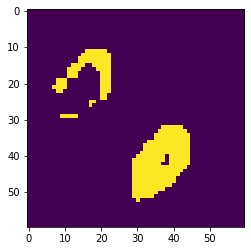

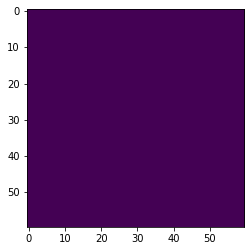

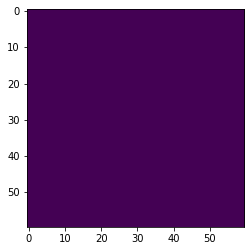

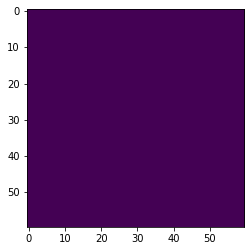

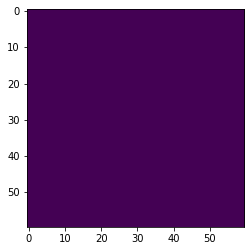

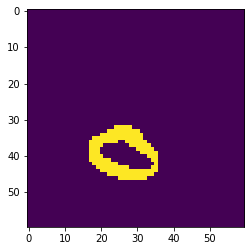

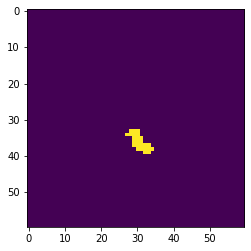

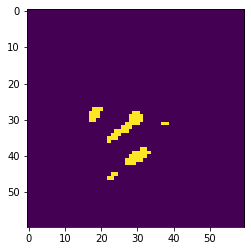

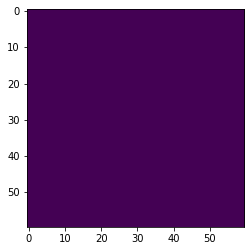

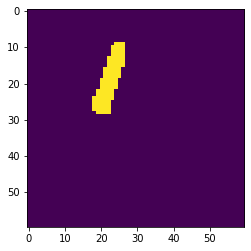

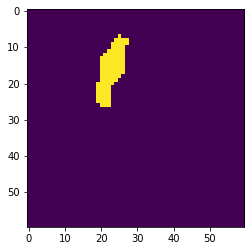

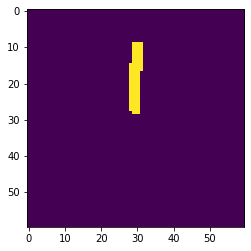

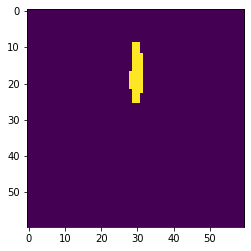

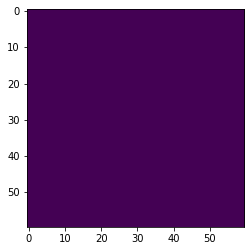

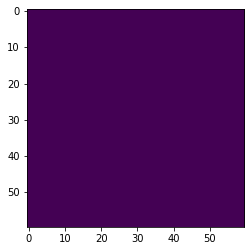

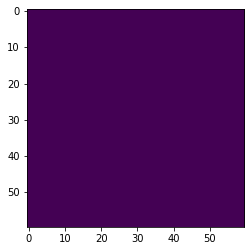

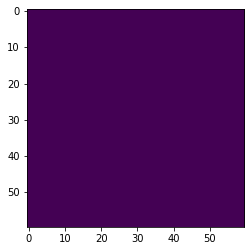

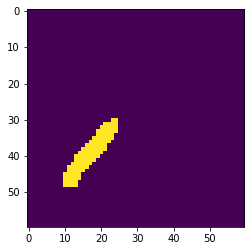

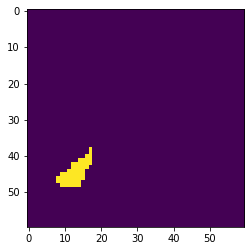

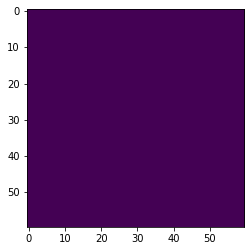

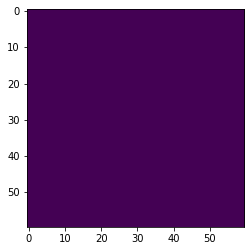

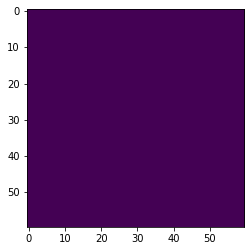

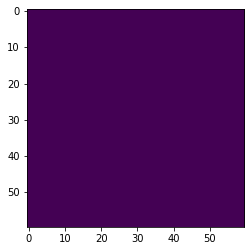

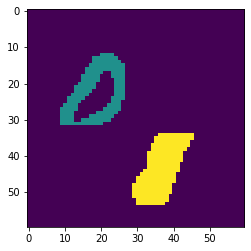

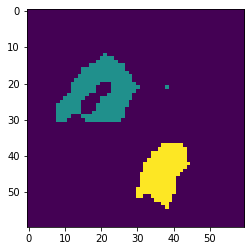

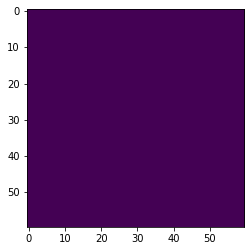

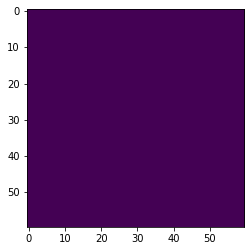

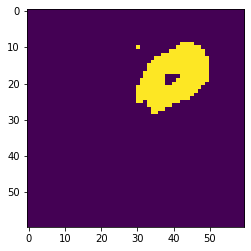

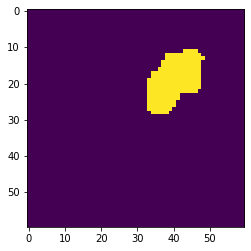

  3%|▎         | 6/200 [00:26<14:28,  4.48s/it]

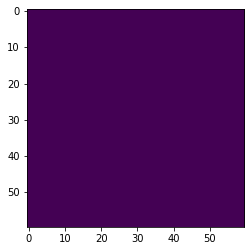

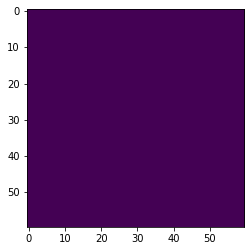

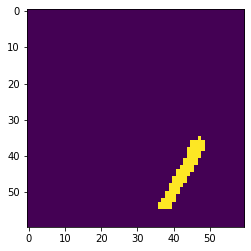

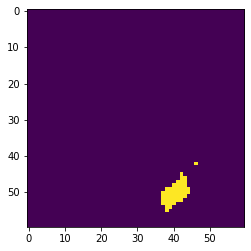

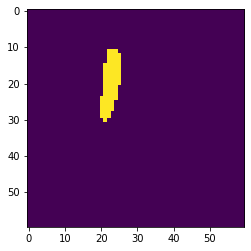

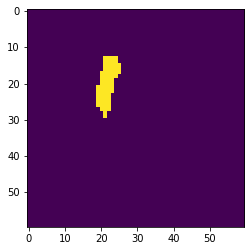

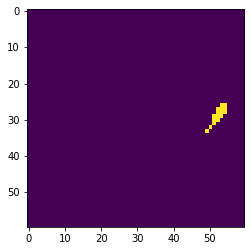

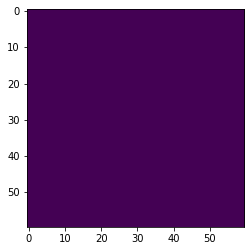

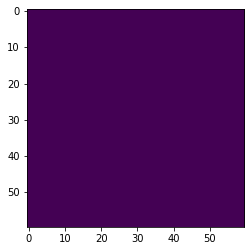

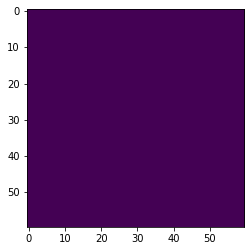

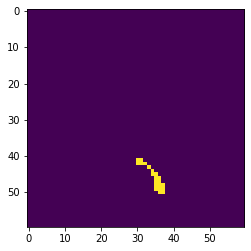

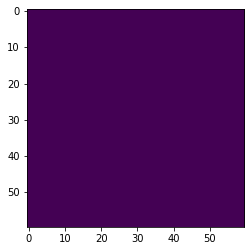

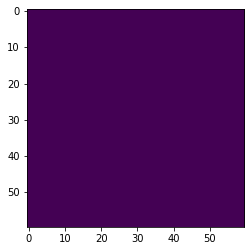

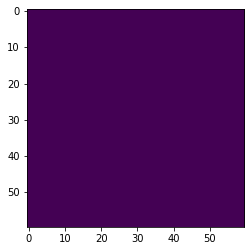

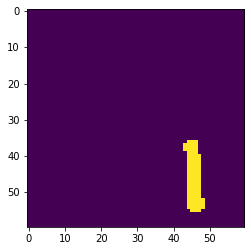

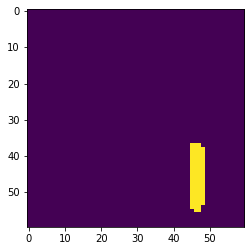

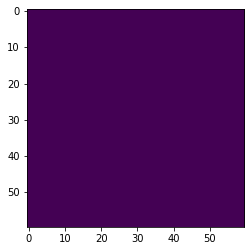

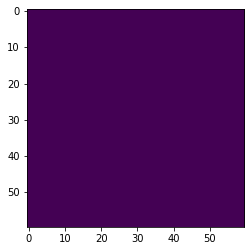

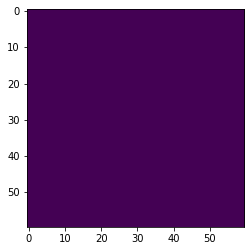

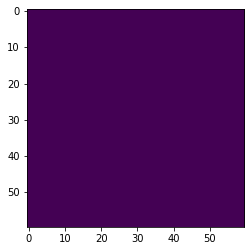

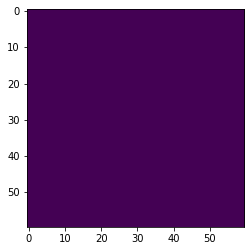

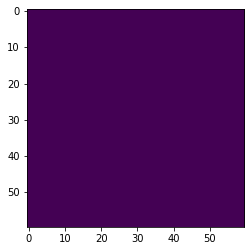

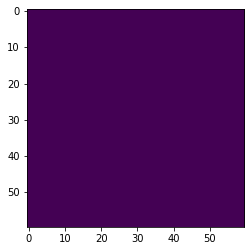

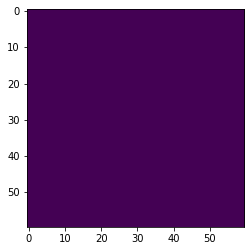

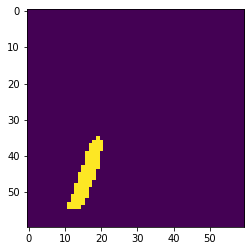

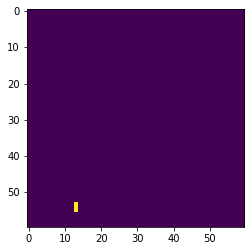

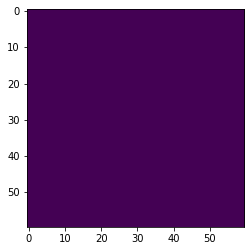

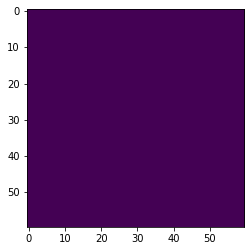

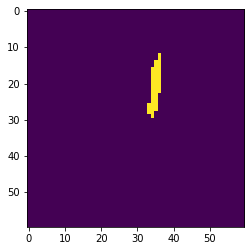

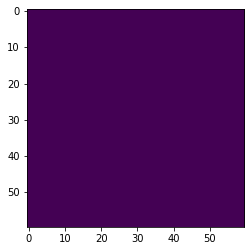

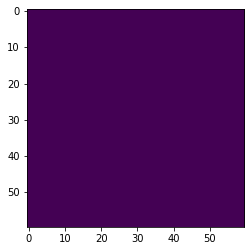

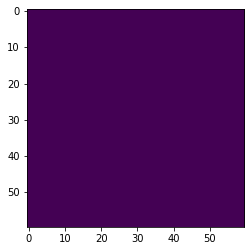

  4%|▎         | 7/200 [00:31<14:25,  4.48s/it]

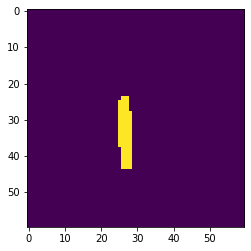

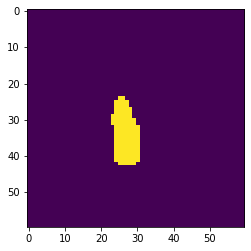

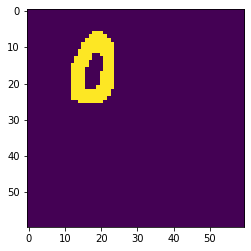

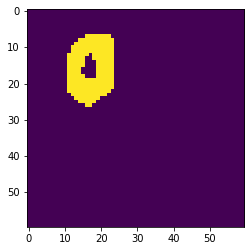

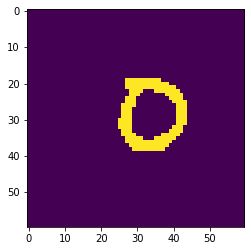

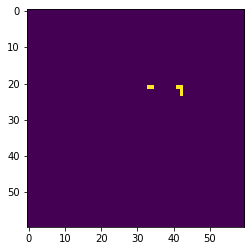

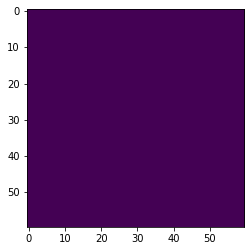

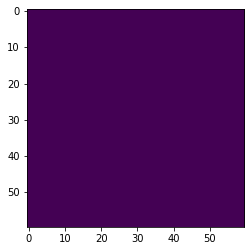

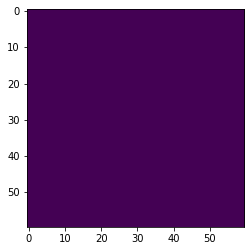

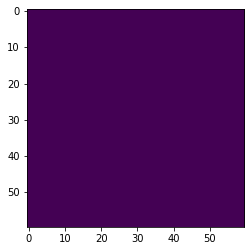

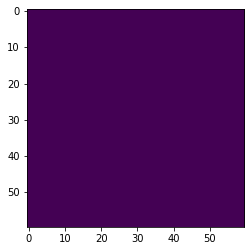

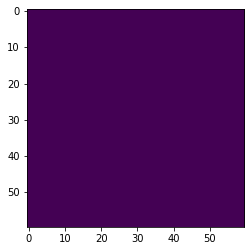

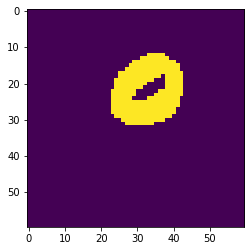

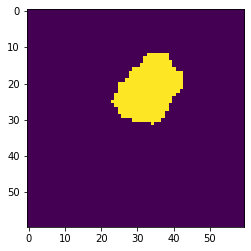

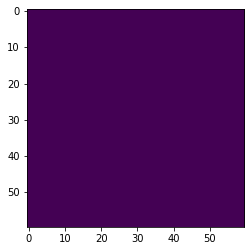

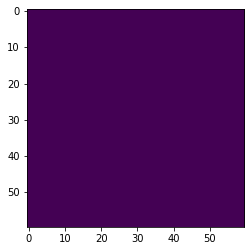

  4%|▎         | 7/200 [00:33<15:15,  4.74s/it]


KeyboardInterrupt: ignored

In [ ]:
from trainer import Trainer_PseudoLabel_ImageLabels
# Initialize dataloader, optimizer and trainer
model = PseudoSeg(n_classes_per_task=[len(_tasks[0])+1], conv_filters=64)
model = model.cuda()
optimizer = torch.optim.Adam(lr = 0.0005, params=model.parameters())

continual_mnist = ContinualMnist(n_train=1000, n_test=1000, batch_size=32, tasks=_tasks, return_im_level_label=True)

evaluater = EvaluaterCallback(model, ["confusion_matrix"], callback_frequency="task", n_classes=11, save_matrices=True, out_idx=2)

trainer = Trainer_PseudoSeg(model,
                  n_classes=[3],
                  optim=optimizer,
                  from_new_class = 0,
                  callbacks=[evaluater],
                  show_preds=False)

meta_train(n_tasks = len(_tasks),
           epochs = 500,
           scenario = continual_mnist, 
           trainer=trainer,
           evaluater=evaluater,
           animation_path="nothing_yet",
           pass_first_step = False)

In [ ]:
continual_mnist = ContinualMnist(n_train=500, n_test=1000, batch_size=1, tasks=_tasks, return_im_level_label=True)

In [ ]:
cam = CAM(trainer.model, "cam", "classif")

In [ ]:
data = next(iter(continual_mnist.train_stream))

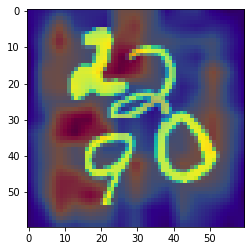

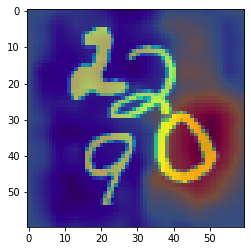

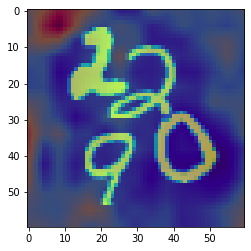

In [ ]:
import torch.nn.functional as F
model.eval()
with torch.no_grad():
  _, out, _ = trainer.model(data[0].cuda().float())
  for i in range(3):
    activation_map = cam(i, out)
    activation_map = F.interpolate(activation_map.unsqueeze(0).unsqueeze(0), (60,60), mode="bilinear", align_corners=True)
    plt.imshow(data[0][0,0])
    plt.imshow(activation_map[0,0].cpu().numpy(), alpha=0.3, cmap="jet")
    plt.show()

torch.Size([1, 15, 15, 1])


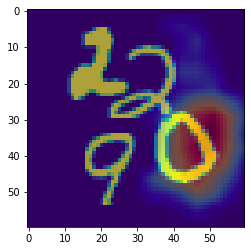

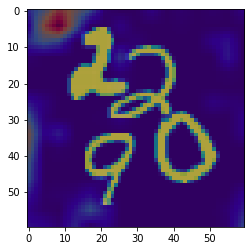

In [ ]:
model.eval()

features, out, _ = trainer.model(data[0].cuda().float())
activation_map = compute_cam(features, out, 3)
print(activation_map[:,:,:,:1].shape)
for i in range(2):
  a_map = F.interpolate(activation_map[:,:,:,i].unsqueeze(0), (60,60), mode="bilinear", align_corners=True)
  plt.imshow(data[0][0,0])
  plt.imshow(a_map[0,0].detach().cpu().numpy(), alpha=0.3, cmap="jet")
  plt.show()

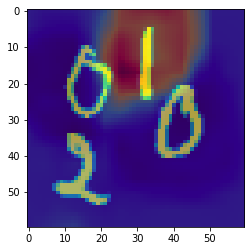

In [ ]:
out

tensor([[ 8.1517, -7.3739, 11.7504]], device='cuda:0')

In [ ]:
with torch.no_grad():
  out,_ = pseudoseg(torch.ones((1, 1, 60, 60)))
  a = cam(0,out)

In [ ]:
a.shape#, out.shape

torch.Size([15, 15])

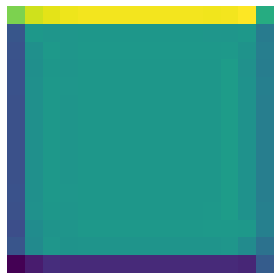

In [ ]:
plt.imshow(a.numpy()); plt.axis('off'); plt.tight_layout(); plt.show()

In [ ]:
def find_results(current_path, filename):
  if filename in os.listdir(current_path):
            x = open(os.path.join(current_path, 
                                  filename)).readlines()
            print(current_path)
            for l in x[-12:-8]:
              print(l)
            print()
            print()

base_path = "experiments/2-2"
for n_train in os.listdir(base_path):
  for batch_size in os.listdir(os.path.join(base_path, n_train)):
    for epoch in os.listdir(os.path.join(base_path, n_train, batch_size)):
      for method in os.listdir(os.path.join(base_path, n_train, batch_size, epoch)):
        for lambda_distillation in os.listdir(os.path.join(base_path, n_train, batch_size, epoch, method)):
          current_path = os.path.join(base_path, 
                                      n_train,
                                      batch_size, 
                                      epoch, 
                                      method, 
                                      lambda_distillation)
          find_results(current_path, "training_process.txt") # no distillation
          if lambda_distillation != '0' :
            for encoder_level_distillation in os.listdir(current_path):
              current_path = os.path.join(current_path, encoder_level_distillation)
              for decoder_level_distillation in os.listdir(current_path):
                current_path = os.path.join(current_path, decoder_level_distillation)
                for output_level_distillation in os.listdir(current_path):
                  current_path = os.path.join(current_path, output_level_distillation)
                  find_results(current_path, "training_process.txt") # with distillation
          
          
        

experiments/2-2/1000/72/200/mib/1/False/False/True
Overall stats

|    |   Overall Acc |   Mean Acc |   Mean IoU |

|---:|--------------:|-----------:|-----------:|

|  0 |      0.958789 |   0.763774 |   0.645446 |



experiments/2-2/1000/72/200/mib/10/False/False/True
Overall stats

|    |   Overall Acc |   Mean Acc |   Mean IoU |

|---:|--------------:|-----------:|-----------:|

|  0 |      0.957931 |   0.822508 |   0.655222 |



experiments/2-2/1000/72/200/mib/100/False/False/True
Overall stats

|    |   Overall Acc |   Mean Acc |   Mean IoU |

|---:|--------------:|-----------:|-----------:|

|  0 |      0.906244 |   0.486729 |   0.331924 |



experiments/2-2/1000/72/200/mib/0
Overall stats

|    |   Overall Acc |   Mean Acc |   Mean IoU |

|---:|--------------:|-----------:|-----------:|

|  0 |      0.895888 |   0.246483 |   0.197438 |



experiments/2-2/1000/72/200/pseudo_label/0
Overall stats

|    |   Overall Acc |   Mean Acc |   Mean IoU |

|---:|--------------:|-----------:

#Experiments for Fine-tuning model (naive approach)

In [ ]:
# Initialize dataloader, optimizer and trainer

model = simple_seg_model(n_classes_per_task=[len(_tasks[0])+1])
model = model.cuda()
optimizer = torch.optim.Adam(lr = 0.0005, params=model.parameters())

continual_mnist = ContinualMnist(n_train=5000, n_test=2500, batch_size=72, tasks=_tasks)

evaluater = EvaluaterCallback(model, ["confusion_matrix"], callback_frequency="epoch", n_classes=11, save_matrices=True)

trainer = Trainer(model,
                  n_classes=[3],
                  optim=optimizer,
                  callbacks=[evaluater])


11501568/11490434 [==============================] - 0s 0us/step


In [ ]:
meta_train(n_tasks = len(_tasks),
           epochs = 100,
           scenario = continual_mnist, 
           trainer=trainer,
           evaluater=evaluater,
           memory=None,
           animation_path='naive')

*******
Task #0
*******
Classes to learn:
-1 0 1
*******


  0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
100%|██████████| 100/100 [01:35<00:00,  1.04it/s]



Overall stats
|    |   Overall Acc |   Mean Acc |   Mean IoU |
|---:|--------------:|-----------:|-----------:|
|  0 |      0.991925 |   0.942679 |   0.893262 |
Class IoU
|    |       -1 |        0 |       1 | 2   | 3   | 4   | 5   | 6   | 7   | 8   | 9   |
|---:|---------:|---------:|--------:|:----|:----|:----|:----|:----|:----|:----|:----|
|  0 | 0.991616 | 0.848289 | 0.83988 | X   | X   | X   | X   | X   | X   | X   | X   |
Class Acc
|    |       -1 |       0 |       1 | 2   | 3   | 4   | 5   | 6   | 7   | 8   | 9   |
|---:|---------:|--------:|--------:|:----|:----|:----|:----|:----|:----|:----|:----|
|  0 | 0.995617 | 0.92524 | 0.90718 | X   | X   | X   | X   | X   | X   | X   | X   |

####################################
Next Task
####################################
*******
Task #1
*******
Classes to learn:
-1 2 3
*******


100%|██████████| 100/100 [01:49<00:00,  1.09s/it]



Overall stats
|    |   Overall Acc |   Mean Acc |   Mean IoU |
|---:|--------------:|-----------:|-----------:|
|  0 |      0.962181 |   0.563367 |   0.521989 |
Class IoU
|    |       -1 |   0 |   1 |        2 |        3 | 4   | 5   | 6   | 7   | 8   | 9   |
|---:|---------:|----:|----:|---------:|---------:|:----|:----|:----|:----|:----|:----|
|  0 | 0.961514 |   0 |   0 | 0.816029 | 0.832403 | X   | X   | X   | X   | X   | X   |
Class Acc
|    |     -1 |   0 |   1 |       2 |        3 | 4   | 5   | 6   | 7   | 8   | 9   |
|---:|-------:|----:|----:|--------:|---------:|:----|:----|:----|:----|:----|:----|
|  0 | 0.9967 |   0 |   0 | 0.91157 | 0.908566 | X   | X   | X   | X   | X   | X   |

####################################
Next Task
####################################
*******
Task #2
*******
Classes to learn:
-1 4 5
*******


100%|██████████| 100/100 [01:54<00:00,  1.14s/it]



Overall stats
|    |   Overall Acc |   Mean Acc |   Mean IoU |
|---:|--------------:|-----------:|-----------:|
|  0 |      0.938506 |   0.398659 |   0.363912 |
Class IoU
|    |       -1 |   0 |   1 |   2 |   3 |        4 |        5 | 6   | 7   | 8   | 9   |
|---:|---------:|----:|----:|----:|----:|---------:|---------:|:----|:----|:----|:----|
|  0 | 0.937676 |   0 |   0 |   0 |   0 | 0.806767 | 0.802941 | X   | X   | X   | X   |
Class Acc
|    |       -1 |   0 |   1 |   2 |   3 |        4 |        5 | 6   | 7   | 8   | 9   |
|---:|---------:|----:|----:|----:|----:|---------:|---------:|:----|:----|:----|:----|
|  0 | 0.997556 |   0 |   0 |   0 |   0 | 0.909349 | 0.883711 | X   | X   | X   | X   |

####################################
Next Task
####################################
*******
Task #3
*******
Classes to learn:
-1 6 7
*******


100%|██████████| 100/100 [02:08<00:00,  1.29s/it]



Overall stats
|    |   Overall Acc |   Mean Acc |   Mean IoU |
|---:|--------------:|-----------:|-----------:|
|  0 |      0.920117 |   0.314419 |   0.279451 |
Class IoU
|    |       -1 |   0 |   1 |   2 |   3 |   4 |   5 |        6 |        7 | 8   | 9   |
|---:|---------:|----:|----:|----:|----:|----:|----:|---------:|---------:|:----|:----|
|  0 | 0.920111 |   0 |   0 |   0 |   0 |   0 |   0 | 0.828025 | 0.766919 | X   | X   |
Class Acc
|    |       -1 |   0 |   1 |   2 |   3 |   4 |   5 |      6 |        7 | 8   | 9   |
|---:|---------:|----:|----:|----:|----:|----:|----:|-------:|---------:|:----|:----|
|  0 | 0.998165 |   0 |   0 |   0 |   0 |   0 |   0 | 0.9093 | 0.922308 | X   | X   |

####################################
Next Task
####################################
*******
Task #4
*******
Classes to learn:
-1 8 9
*******


100%|██████████| 100/100 [02:11<00:00,  1.31s/it]



Overall stats
|    |   Overall Acc |   Mean Acc |   Mean IoU |
|---:|--------------:|-----------:|-----------:|
|  0 |       0.89698 |   0.255952 |   0.227844 |
Class IoU
|    |       -1 |   0 |   1 |   2 |   3 |   4 |   5 |   6 |   7 |        8 |        9 |
|---:|---------:|----:|----:|----:|----:|----:|----:|----:|----:|---------:|---------:|
|  0 | 0.896159 |   0 |   0 |   0 |   0 |   0 |   0 |   0 |   0 | 0.805637 | 0.804489 |
Class Acc
|    |       -1 |   0 |   1 |   2 |   3 |   4 |   5 |   6 |   7 |        8 |        9 |
|---:|---------:|----:|----:|----:|----:|----:|----:|----:|----:|---------:|---------:|
|  0 | 0.998263 |   0 |   0 |   0 |   0 |   0 |   0 |   0 |   0 | 0.916734 | 0.900476 |


#Distillation
##Output-level distillation loss

In [ ]:
model = simple_seg_model(n_classes_per_task=[len(_tasks[0])+1])
model = model.cuda()
optimizer = torch.optim.Adam(lr = 0.0005, params=model.parameters())

continual_mnist = ContinualMnist(n_train=5000, n_test=1000, batch_size=72, tasks=_tasks)

evaluater = EvaluaterCallback(model, ["confusion_matrix"], callback_frequency="epoch", n_classes=11, save_matrices=True)

trainer = Trainer_distillation(model,
                  n_classes=[3],
                  optim=optimizer,
                  from_new_class = 0,
                  lambda_distill=10,
                  output_level_distill=True,
                  callbacks=[evaluater])


In [ ]:
meta_train(n_tasks = len(_tasks),
           epochs = 200,
           scenario = continual_mnist, 
           trainer=trainer,
           evaluater=evaluater,
           animation_path="output_level_distillation_ntrain5000_epochs200")

*******
Task #0
*******
Classes to learn:
-1 0 1
*******


100%|██████████| 200/200 [02:47<00:00,  1.19it/s]



Overall stats
|    |   Overall Acc |   Mean Acc |   Mean IoU |
|---:|--------------:|-----------:|-----------:|
|  0 |      0.994078 |   0.945941 |   0.914837 |
Class IoU
|    |       -1 |        0 |        1 | 2   | 3   | 4   | 5   | 6   | 7   | 8   | 9   |
|---:|---------:|---------:|---------:|:----|:----|:----|:----|:----|:----|:----|:----|
|  0 | 0.993843 | 0.884215 | 0.866452 | X   | X   | X   | X   | X   | X   | X   | X   |
Class Acc
|    |       -1 |        0 |        1 | 2   | 3   | 4   | 5   | 6   | 7   | 8   | 9   |
|---:|---------:|---------:|---------:|:----|:----|:----|:----|:----|:----|:----|:----|
|  0 | 0.997575 | 0.927281 | 0.912968 | X   | X   | X   | X   | X   | X   | X   | X   |

####################################
Next Task
####################################
*******
Task #1
*******
Classes to learn:
-1 2 3
*******


100%|██████████| 200/200 [05:18<00:00,  1.59s/it]



Overall stats
|    |   Overall Acc |   Mean Acc |   Mean IoU |
|---:|--------------:|-----------:|-----------:|
|  0 |      0.988196 |   0.953901 |   0.857909 |
Class IoU
|    |       -1 |       0 |      1 |        2 |        3 | 4   | 5   | 6   | 7   | 8   | 9   |
|---:|---------:|--------:|-------:|---------:|---------:|:----|:----|:----|:----|:----|:----|
|  0 | 0.988523 | 0.84873 | 0.8058 | 0.826181 | 0.820309 | X   | X   | X   | X   | X   | X   |
Class Acc
|    |       -1 |        0 |        1 |        2 |        3 | 4   | 5   | 6   | 7   | 8   | 9   |
|---:|---------:|---------:|---------:|---------:|---------:|:----|:----|:----|:----|:----|:----|
|  0 | 0.991212 | 0.975785 | 0.949027 | 0.925399 | 0.928083 | X   | X   | X   | X   | X   | X   |

####################################
Next Task
####################################
*******
Task #2
*******
Classes to learn:
-1 4 5
*******


100%|██████████| 200/200 [05:21<00:00,  1.61s/it]



Overall stats
|    |   Overall Acc |   Mean Acc |   Mean IoU |
|---:|--------------:|-----------:|-----------:|
|  0 |      0.977607 |   0.941434 |   0.780645 |
Class IoU
|    |       -1 |       0 |        1 |        2 |        3 |        4 |       5 | 6   | 7   | 8   | 9   |
|---:|---------:|--------:|---------:|---------:|---------:|---------:|--------:|:----|:----|:----|:----|
|  0 | 0.978962 | 0.74915 | 0.676023 | 0.727604 | 0.778002 | 0.802756 | 0.75202 | X   | X   | X   | X   |
Class Acc
|    |       -1 |        0 |       1 |        2 |        3 |       4 |       5 | 6   | 7   | 8   | 9   |
|---:|---------:|---------:|--------:|---------:|---------:|--------:|--------:|:----|:----|:----|:----|
|  0 | 0.981293 | 0.980176 | 0.95558 | 0.936812 | 0.924356 | 0.90131 | 0.91051 | X   | X   | X   | X   |

####################################
Next Task
####################################
*******
Task #3
*******
Classes to learn:
-1 6 7
*******


100%|██████████| 200/200 [05:59<00:00,  1.80s/it]



Overall stats
|    |   Overall Acc |   Mean Acc |   Mean IoU |
|---:|--------------:|-----------:|-----------:|
|  0 |      0.960762 |   0.931709 |   0.706883 |
Class IoU
|    |       -1 |        0 |        1 |        2 |        3 |        4 |        5 |        6 |        7 | 8   | 9   |
|---:|---------:|---------:|---------:|---------:|---------:|---------:|---------:|---------:|---------:|:----|:----|
|  0 | 0.963543 | 0.647261 | 0.518086 | 0.629075 | 0.632562 | 0.773288 | 0.695142 | 0.774186 | 0.728803 | X   | X   |
Class Acc
|    |       -1 |        0 |       1 |       2 |        3 |        4 |        5 |        6 |        7 | 8   | 9   |
|---:|---------:|---------:|--------:|--------:|---------:|---------:|---------:|---------:|---------:|:----|:----|
|  0 | 0.964288 | 0.971504 | 0.91965 | 0.88314 | 0.947523 | 0.922411 | 0.935183 | 0.907143 | 0.934538 | X   | X   |

####################################
Next Task
####################################
*******
Task #4
*******
Classes

100%|██████████| 200/200 [06:18<00:00,  1.89s/it]



Overall stats
|    |   Overall Acc |   Mean Acc |   Mean IoU |
|---:|--------------:|-----------:|-----------:|
|  0 |      0.945159 |     0.9124 |    0.67882 |
Class IoU
|    |       -1 |        0 |        1 |        2 |        3 |       4 |        5 |        6 |        7 |        8 |        9 |
|---:|---------:|---------:|---------:|---------:|---------:|--------:|---------:|---------:|---------:|---------:|---------:|
|  0 | 0.950082 | 0.580728 | 0.363543 | 0.598795 | 0.583828 | 0.75816 | 0.683316 | 0.777141 | 0.738784 | 0.700728 | 0.731909 |
Class Acc
|    |       -1 |        0 |        1 |        2 |        3 |        4 |        5 |        6 |        7 |        8 |        9 |
|---:|---------:|---------:|---------:|---------:|---------:|---------:|---------:|---------:|---------:|---------:|---------:|
|  0 | 0.950321 | 0.966066 | 0.916938 | 0.876796 | 0.936702 | 0.893237 | 0.922812 | 0.878904 | 0.938222 | 0.900747 | 0.855656 |


# MiB

In [ ]:
# Initialize dataloader, optimizer and trainer
model = simple_seg_model(n_classes_per_task=[len(_tasks[0])+1])
model = model.cuda()
optimizer = torch.optim.Adam(lr = 0.0005, params=model.parameters())

continual_mnist = ContinualMnist(n_train=5000, n_test=1000, batch_size=72, tasks=_tasks)

evaluater = EvaluaterCallback(model, ["confusion_matrix"], callback_frequency="epoch", n_classes=11, save_matrices=True)

trainer = Trainer_MIB(model,
                  n_classes=[3],
                  optim=optimizer,
                  from_new_class = 0,
                  lambda_distill=10,
                  output_level_distill=True,
                  callbacks=[evaluater])

In [ ]:
#Note : pour sauvegarder les prints dans un fichier
#import contextlib
 
#file_path = 'randomfile.txt'
#with open(file_path, "w") as o:
#    with contextlib.redirect_stdout(o):
#         ...

In [ ]:
meta_train(n_tasks = len(_tasks),
           epochs = 200,
           scenario = continual_mnist, 
           trainer=trainer,
           evaluater=evaluater,
           animation_path="MIB_lambda10_ntrain1000_epochs200")

*******
Task #0
*******
Classes to learn:
-1 0 1
*******


100%|██████████| 200/200 [02:50<00:00,  1.17it/s]



Overall stats
|    |   Overall Acc |   Mean Acc |   Mean IoU |
|---:|--------------:|-----------:|-----------:|
|  0 |      0.992954 |   0.957715 |   0.905226 |
Class IoU
|    |       -1 |        0 |        1 | 2   | 3   | 4   | 5   | 6   | 7   | 8   | 9   |
|---:|---------:|---------:|---------:|:----|:----|:----|:----|:----|:----|:----|:----|
|  0 | 0.992731 | 0.861754 | 0.861193 | X   | X   | X   | X   | X   | X   | X   | X   |
Class Acc
|    |       -1 |        0 |        1 | 2   | 3   | 4   | 5   | 6   | 7   | 8   | 9   |
|---:|---------:|---------:|---------:|:----|:----|:----|:----|:----|:----|:----|:----|
|  0 | 0.995384 | 0.955269 | 0.922492 | X   | X   | X   | X   | X   | X   | X   | X   |

####################################
Next Task
####################################
*******
Task #1
*******
Classes to learn:
-1 2 3
*******


100%|██████████| 200/200 [05:27<00:00,  1.64s/it]



Overall stats
|    |   Overall Acc |   Mean Acc |   Mean IoU |
|---:|--------------:|-----------:|-----------:|
|  0 |      0.989084 |   0.918544 |   0.868001 |
Class IoU
|    |       -1 |        0 |        1 |        2 |        3 | 4   | 5   | 6   | 7   | 8   | 9   |
|---:|---------:|---------:|---------:|---------:|---------:|:----|:----|:----|:----|:----|:----|
|  0 | 0.989244 | 0.868994 | 0.862793 | 0.791798 | 0.827174 | X   | X   | X   | X   | X   | X   |
Class Acc
|    |       -1 |        0 |        1 |        2 |        3 | 4   | 5   | 6   | 7   | 8   | 9   |
|---:|---------:|---------:|---------:|---------:|---------:|:----|:----|:----|:----|:----|:----|
|  0 | 0.995305 | 0.953208 | 0.897508 | 0.865699 | 0.880998 | X   | X   | X   | X   | X   | X   |

####################################
Next Task
####################################
*******
Task #2
*******
Classes to learn:
-1 4 5
*******


100%|██████████| 200/200 [05:44<00:00,  1.72s/it]



Overall stats
|    |   Overall Acc |   Mean Acc |   Mean IoU |
|---:|--------------:|-----------:|-----------:|
|  0 |       0.98575 |   0.908998 |    0.84377 |
Class IoU
|    |       -1 |        0 |        1 |        2 |        3 |        4 |        5 | 6   | 7   | 8   | 9   |
|---:|---------:|---------:|---------:|---------:|---------:|---------:|---------:|:----|:----|:----|:----|
|  0 | 0.986728 | 0.867528 | 0.863911 | 0.778685 | 0.804365 | 0.792522 | 0.812651 | X   | X   | X   | X   |
Class Acc
|    |       -1 |        0 |        1 |        2 |        3 |        4 |        5 | 6   | 7   | 8   | 9   |
|---:|---------:|---------:|---------:|---------:|---------:|---------:|---------:|:----|:----|:----|:----|
|  0 | 0.993917 | 0.946519 | 0.925926 | 0.850529 | 0.876265 | 0.874665 | 0.895164 | X   | X   | X   | X   |

####################################
Next Task
####################################
*******
Task #3
*******
Classes to learn:
-1 6 7
*******


100%|██████████| 200/200 [06:28<00:00,  1.94s/it]



Overall stats
|    |   Overall Acc |   Mean Acc |   Mean IoU |
|---:|--------------:|-----------:|-----------:|
|  0 |      0.983598 |   0.907625 |   0.829804 |
Class IoU
|    |       -1 |        0 |       1 |        2 |        3 |        4 |        5 |        6 |        7 | 8   | 9   |
|---:|---------:|---------:|--------:|---------:|---------:|---------:|---------:|---------:|---------:|:----|:----|
|  0 | 0.987308 | 0.865156 | 0.86607 | 0.788392 | 0.794024 | 0.796452 | 0.790051 | 0.813186 | 0.767593 | X   | X   |
Class Acc
|    |       -1 |        0 |        1 |        2 |        3 |        4 |        5 |        6 |        7 | 8   | 9   |
|---:|---------:|---------:|---------:|---------:|---------:|---------:|---------:|---------:|---------:|:----|:----|
|  0 | 0.993341 | 0.939739 | 0.925791 | 0.867896 | 0.889704 | 0.894198 | 0.881324 | 0.903202 | 0.873434 | X   | X   |

####################################
Next Task
####################################
*******
Task #4
*******
Clas

100%|██████████| 200/200 [06:26<00:00,  1.93s/it]



Overall stats
|    |   Overall Acc |   Mean Acc |   Mean IoU |
|---:|--------------:|-----------:|-----------:|
|  0 |      0.980743 |    0.89543 |   0.815073 |
Class IoU
|    |       -1 |        0 |        1 |        2 |        3 |        4 |       5 |        6 |        7 |        8 |        9 |
|---:|---------:|---------:|---------:|---------:|---------:|---------:|--------:|---------:|---------:|---------:|---------:|
|  0 | 0.988007 | 0.861833 | 0.851327 | 0.745962 | 0.790688 | 0.780746 | 0.77715 | 0.798396 | 0.742697 | 0.837762 | 0.791239 |
Class Acc
|    |       -1 |        0 |        1 |        2 |       3 |        4 |        5 |        6 |        7 |        8 |       9 |
|---:|---------:|---------:|---------:|---------:|--------:|---------:|---------:|---------:|---------:|---------:|--------:|
|  0 | 0.994378 | 0.931205 | 0.913872 | 0.835039 | 0.88267 | 0.889123 | 0.848157 | 0.867385 | 0.887881 | 0.911866 | 0.88816 |


#Pseudo-labeling

In [ ]:
from trainer import Trainer_PseudoLabel
# Initialize dataloader, optimizer and trainer
model = simple_seg_model(n_classes_per_task=[len(_tasks[0])+1])
model = model.cuda()
optimizer = torch.optim.Adam(lr = 0.0005, params=model.parameters())

continual_mnist = ContinualMnist(n_train=5000, n_test=1000, batch_size=72, tasks=_tasks)

evaluater = EvaluaterCallback(model, ["confusion_matrix"], callback_frequency="epoch", n_classes=11, save_matrices=True)

trainer = Trainer_PseudoLabel(model,
                  n_classes=[3],
                  optim=optimizer,
                  from_new_class = 0,
                  callbacks=[evaluater])

*******
Task #0
*******
Classes to learn:
-1 0 1
*******


100%|██████████| 200/200 [02:53<00:00,  1.15it/s]



Overall stats
|    |   Overall Acc |   Mean Acc |   Mean IoU |
|---:|--------------:|-----------:|-----------:|
|  0 |      0.993927 |   0.954471 |   0.913444 |
Class IoU
|    |       -1 |        0 |        1 | 2   | 3   | 4   | 5   | 6   | 7   | 8   | 9   |
|---:|---------:|---------:|---------:|:----|:----|:----|:----|:----|:----|:----|:----|
|  0 | 0.993751 | 0.875523 | 0.871059 | X   | X   | X   | X   | X   | X   | X   | X   |
Class Acc
|    |       -1 |       0 |        1 | 2   | 3   | 4   | 5   | 6   | 7   | 8   | 9   |
|---:|---------:|--------:|---------:|:----|:----|:----|:----|:----|:----|:----|:----|
|  0 | 0.996816 | 0.93469 | 0.931908 | X   | X   | X   | X   | X   | X   | X   | X   |

####################################
Next Task
####################################
*******
Task #1
*******
Classes to learn:
-1 2 3
*******


100%|██████████| 200/200 [03:30<00:00,  1.05s/it]



Overall stats
|    |   Overall Acc |   Mean Acc |   Mean IoU |
|---:|--------------:|-----------:|-----------:|
|  0 |      0.988858 |   0.931454 |   0.862699 |
Class IoU
|    |       -1 |        0 |        1 |       2 |        3 | 4   | 5   | 6   | 7   | 8   | 9   |
|---:|---------:|---------:|---------:|--------:|---------:|:----|:----|:----|:----|:----|:----|
|  0 | 0.989286 | 0.848544 | 0.831308 | 0.81621 | 0.828147 | X   | X   | X   | X   | X   | X   |
Class Acc
|    |       -1 |        0 |        1 |        2 |        3 | 4   | 5   | 6   | 7   | 8   | 9   |
|---:|---------:|---------:|---------:|---------:|---------:|:----|:----|:----|:----|:----|:----|
|  0 | 0.994205 | 0.934559 | 0.933601 | 0.880257 | 0.914647 | X   | X   | X   | X   | X   | X   |

####################################
Next Task
####################################
*******
Task #2
*******
Classes to learn:
-1 4 5
*******


100%|██████████| 200/200 [03:43<00:00,  1.12s/it]



Overall stats
|    |   Overall Acc |   Mean Acc |   Mean IoU |
|---:|--------------:|-----------:|-----------:|
|  0 |      0.985626 |   0.922481 |   0.837539 |
Class IoU
|    |       -1 |        0 |        1 |        2 |        3 |        4 |        5 | 6   | 7   | 8   | 9   |
|---:|---------:|---------:|---------:|---------:|---------:|---------:|---------:|:----|:----|:----|:----|
|  0 | 0.987602 | 0.859625 | 0.846159 | 0.759538 | 0.801912 | 0.808048 | 0.799887 | X   | X   | X   | X   |
Class Acc
|    |       -1 |        0 |        1 |        2 |        3 |        4 |        5 | 6   | 7   | 8   | 9   |
|---:|---------:|---------:|---------:|---------:|---------:|---------:|---------:|:----|:----|:----|:----|
|  0 | 0.992301 | 0.943839 | 0.917378 | 0.882223 | 0.889399 | 0.932723 | 0.899504 | X   | X   | X   | X   |

####################################
Next Task
####################################
*******
Task #3
*******
Classes to learn:
-1 6 7
*******


100%|██████████| 200/200 [04:06<00:00,  1.23s/it]



Overall stats
|    |   Overall Acc |   Mean Acc |   Mean IoU |
|---:|--------------:|-----------:|-----------:|
|  0 |      0.982987 |   0.904757 |    0.81766 |
Class IoU
|    |       -1 |        0 |        1 |        2 |        3 |        4 |        5 |        6 |        7 | 8   | 9   |
|---:|---------:|---------:|---------:|---------:|---------:|---------:|---------:|---------:|---------:|:----|:----|
|  0 | 0.988369 | 0.850946 | 0.850677 | 0.743132 | 0.767267 | 0.783382 | 0.749467 | 0.826275 | 0.799428 | X   | X   |
Class Acc
|    |       -1 |        0 |        1 |       2 |        3 |       4 |        5 |        6 |        7 | 8   | 9   |
|---:|---------:|---------:|---------:|--------:|---------:|--------:|---------:|---------:|---------:|:----|:----|
|  0 | 0.993105 | 0.917172 | 0.892547 | 0.84064 | 0.893285 | 0.90794 | 0.854743 | 0.917782 | 0.925598 | X   | X   |

####################################
Next Task
####################################
*******
Task #4
*******
Classes

100%|██████████| 200/200 [03:58<00:00,  1.19s/it]



Overall stats
|    |   Overall Acc |   Mean Acc |   Mean IoU |
|---:|--------------:|-----------:|-----------:|
|  0 |       0.97991 |   0.878932 |   0.801369 |
Class IoU
|    |       -1 |        0 |        1 |        2 |        3 |        4 |        5 |        6 |        7 |        8 |        9 |
|---:|---------:|---------:|---------:|---------:|---------:|---------:|---------:|---------:|---------:|---------:|---------:|
|  0 | 0.988914 | 0.847721 | 0.829932 | 0.715232 | 0.724035 | 0.784908 | 0.729348 | 0.813106 | 0.802341 | 0.785321 | 0.794208 |
Class Acc
|    |      -1 |        0 |        1 |        2 |        3 |        4 |       5 |       6 |        7 |        8 |        9 |
|---:|--------:|---------:|---------:|---------:|---------:|---------:|--------:|--------:|---------:|---------:|---------:|
|  0 | 0.99604 | 0.903243 | 0.863118 | 0.776772 | 0.841284 | 0.875354 | 0.85269 | 0.89101 | 0.873799 | 0.897905 | 0.897034 |


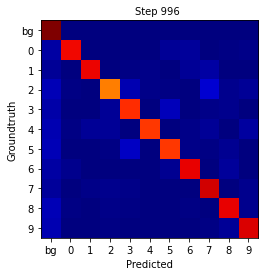

In [ ]:
meta_train(n_tasks = len(_tasks),
           epochs = 200,
           scenario = continual_mnist, 
           trainer=trainer,
           evaluater=evaluater,
           animation_path="pseudolabel")

# Pseudo labeling with image level labels

In [ ]:
from trainer import Trainer_PseudoLabel_ImageLabels
# Initialize dataloader, optimizer and trainer
model = simple_seg_model(n_classes_per_task=[len(_tasks[0])+1])
model = model.cuda()
optimizer = torch.optim.Adam(lr = 0.0005, params=model.parameters())

continual_mnist = ContinualMnist(n_train=500, n_test=1000, batch_size=72, tasks=_tasks, return_im_level_label=True)

evaluater = EvaluaterCallback(model, ["confusion_matrix"], callback_frequency="epoch", n_classes=11, save_matrices=True)

trainer = Trainer_PseudoLabel_ImageLabels(model,
                  n_classes=[3],
                  optim=optimizer,
                  from_new_class = 0,
                  callbacks=[evaluater])

*******
Task #0
*******
Classes to learn:
-1 0 1
*******


100%|██████████| 200/200 [02:47<00:00,  1.19it/s]



Overall stats
|    |   Overall Acc |   Mean Acc |   Mean IoU |
|---:|--------------:|-----------:|-----------:|
|  0 |      0.993305 |   0.948355 |   0.912075 |
Class IoU
|    |       -1 |        0 |        1 | 2   | 3   | 4   | 5   | 6   | 7   | 8   | 9   |
|---:|---------:|---------:|---------:|:----|:----|:----|:----|:----|:----|:----|:----|
|  0 | 0.993059 | 0.872139 | 0.871029 | X   | X   | X   | X   | X   | X   | X   | X   |
Class Acc
|    |       -1 |        0 |        1 | 2   | 3   | 4   | 5   | 6   | 7   | 8   | 9   |
|---:|---------:|---------:|---------:|:----|:----|:----|:----|:----|:----|:----|:----|
|  0 | 0.997014 | 0.920222 | 0.927828 | X   | X   | X   | X   | X   | X   | X   | X   |

####################################
Next Task
####################################
*******
Task #1
*******
Classes to learn:
-1 2 3
*******


100%|██████████| 200/200 [03:36<00:00,  1.08s/it]



Overall stats
|    |   Overall Acc |   Mean Acc |   Mean IoU |
|---:|--------------:|-----------:|-----------:|
|  0 |      0.989874 |   0.939977 |   0.875091 |
Class IoU
|    |       -1 |        0 |        1 |        2 |        3 | 4   | 5   | 6   | 7   | 8   | 9   |
|---:|---------:|---------:|---------:|---------:|---------:|:----|:----|:----|:----|:----|:----|
|  0 | 0.990693 | 0.863008 | 0.865029 | 0.812005 | 0.844719 | X   | X   | X   | X   | X   | X   |
Class Acc
|    |       -1 |        0 |        1 |        2 |        3 | 4   | 5   | 6   | 7   | 8   | 9   |
|---:|---------:|---------:|---------:|---------:|---------:|:----|:----|:----|:----|:----|:----|
|  0 | 0.994452 | 0.916055 | 0.922337 | 0.930589 | 0.936454 | X   | X   | X   | X   | X   | X   |

####################################
Next Task
####################################
*******
Task #2
*******
Classes to learn:
-1 4 5
*******


100%|██████████| 200/200 [03:42<00:00,  1.11s/it]



Overall stats
|    |   Overall Acc |   Mean Acc |   Mean IoU |
|---:|--------------:|-----------:|-----------:|
|  0 |      0.986874 |   0.912531 |   0.844126 |
Class IoU
|    |       -1 |        0 |        1 |        2 |        3 |        4 |      5 | 6   | 7   | 8   | 9   |
|---:|---------:|---------:|---------:|---------:|---------:|---------:|-------:|:----|:----|:----|:----|
|  0 | 0.989128 | 0.854741 | 0.855673 | 0.795687 | 0.795788 | 0.847766 | 0.7701 | X   | X   | X   | X   |
Class Acc
|    |       -1 |        0 |        1 |        2 |        3 |       4 |       5 | 6   | 7   | 8   | 9   |
|---:|---------:|---------:|---------:|---------:|---------:|--------:|--------:|:----|:----|:----|:----|
|  0 | 0.994742 | 0.906875 | 0.901091 | 0.881424 | 0.856417 | 0.93364 | 0.91353 | X   | X   | X   | X   |

####################################
Next Task
####################################
*******
Task #3
*******
Classes to learn:
-1 6 7
*******


100%|██████████| 200/200 [04:05<00:00,  1.23s/it]



Overall stats
|    |   Overall Acc |   Mean Acc |   Mean IoU |
|---:|--------------:|-----------:|-----------:|
|  0 |      0.984868 |   0.897309 |   0.838278 |
Class IoU
|    |       -1 |        0 |        1 |        2 |        3 |        4 |        5 |        6 |        7 | 8   | 9   |
|---:|---------:|---------:|---------:|---------:|---------:|---------:|---------:|---------:|---------:|:----|:----|
|  0 | 0.988422 | 0.850638 | 0.835078 | 0.790828 | 0.808233 | 0.827193 | 0.791515 | 0.819522 | 0.833069 | X   | X   |
Class Acc
|    |       -1 |        0 |        1 |        2 |        3 |        4 |        5 |        6 |        7 | 8   | 9   |
|---:|---------:|---------:|---------:|---------:|---------:|---------:|---------:|---------:|---------:|:----|:----|
|  0 | 0.996113 | 0.889497 | 0.870263 | 0.842463 | 0.872885 | 0.894372 | 0.858748 | 0.930416 | 0.921028 | X   | X   |

####################################
Next Task
####################################
*******
Task #4
*******
C

100%|██████████| 200/200 [04:11<00:00,  1.26s/it]



Overall stats
|    |   Overall Acc |   Mean Acc |   Mean IoU |
|---:|--------------:|-----------:|-----------:|
|  0 |      0.980159 |   0.887329 |   0.816553 |
Class IoU
|    |       -1 |        0 |        1 |       2 |        3 |        4 |        5 |        6 |        7 |        8 |        9 |
|---:|---------:|---------:|---------:|--------:|---------:|---------:|---------:|---------:|---------:|---------:|---------:|
|  0 | 0.986252 | 0.831943 | 0.841151 | 0.75966 | 0.782031 | 0.812736 | 0.750604 | 0.809043 | 0.776995 | 0.812007 | 0.819665 |
Class Acc
|    |      -1 |        0 |        1 |        2 |        3 |       4 |       5 |        6 |        7 |        8 |        9 |
|---:|--------:|---------:|---------:|---------:|---------:|--------:|--------:|---------:|---------:|---------:|---------:|
|  0 | 0.99486 | 0.893494 | 0.872093 | 0.825443 | 0.826489 | 0.88283 | 0.83638 | 0.911452 | 0.850047 | 0.939605 | 0.927925 |


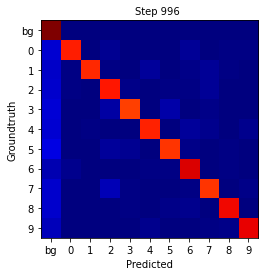

In [ ]:
meta_train(n_tasks = len(_tasks),
           epochs = 200,
           scenario = continual_mnist, 
           trainer=trainer,
           evaluater=evaluater,
           animation_path="pseudolabel_image_level")

*******
Task #0
*******
Classes to learn:
-1 0 1
*******


100%|██████████| 200/200 [00:31<00:00,  6.43it/s]



Overall stats
|    |   Overall Acc |   Mean Acc |   Mean IoU |
|---:|--------------:|-----------:|-----------:|
|  0 |       0.98144 |   0.796604 |   0.746056 |
Class IoU
|    |       -1 |        0 |        1 | 2   | 3   | 4   | 5   | 6   | 7   | 8   | 9   |
|---:|---------:|---------:|---------:|:----|:----|:----|:----|:----|:----|:----|:----|
|  0 | 0.981471 | 0.666662 | 0.590034 | X   | X   | X   | X   | X   | X   | X   | X   |
Class Acc
|    |       -1 |        0 |       1 | 2   | 3   | 4   | 5   | 6   | 7   | 8   | 9   |
|---:|---------:|---------:|--------:|:----|:----|:----|:----|:----|:----|:----|:----|
|  0 | 0.994261 | 0.780013 | 0.61554 | X   | X   | X   | X   | X   | X   | X   | X   |

####################################
Next Task
####################################
*******
Task #1
*******
Classes to learn:
-1 2 3
*******


100%|██████████| 200/200 [00:44<00:00,  4.49it/s]



Overall stats
|    |   Overall Acc |   Mean Acc |   Mean IoU |
|---:|--------------:|-----------:|-----------:|
|  0 |      0.969341 |   0.734501 |   0.642969 |
Class IoU
|    |     -1 |        0 |        1 |       2 |        3 | 4   | 5   | 6   | 7   | 8   | 9   |
|---:|-------:|---------:|---------:|--------:|---------:|:----|:----|:----|:----|:----|:----|
|  0 | 0.9726 | 0.653263 | 0.547046 | 0.48571 | 0.556226 | X   | X   | X   | X   | X   | X   |
Class Acc
|    |      -1 |        0 |        1 |        2 |        3 | 4   | 5   | 6   | 7   | 8   | 9   |
|---:|--------:|---------:|---------:|---------:|---------:|:----|:----|:----|:----|:----|:----|
|  0 | 0.98945 | 0.716875 | 0.567807 | 0.638934 | 0.759438 | X   | X   | X   | X   | X   | X   |

####################################
Next Task
####################################
*******
Task #2
*******
Classes to learn:
-1 4 5
*******


100%|██████████| 200/200 [00:49<00:00,  4.06it/s]



Overall stats
|    |   Overall Acc |   Mean Acc |   Mean IoU |
|---:|--------------:|-----------:|-----------:|
|  0 |      0.956511 |   0.662104 |   0.536135 |
Class IoU
|    |      -1 |        0 |        1 |        2 |        3 |        4 |        5 | 6   | 7   | 8   | 9   |
|---:|--------:|---------:|---------:|---------:|---------:|---------:|---------:|:----|:----|:----|:----|
|  0 | 0.96871 | 0.621754 | 0.569557 | 0.316852 | 0.309039 | 0.558071 | 0.408962 | X   | X   | X   | X   |
Class Acc
|    |       -1 |        0 |        1 |        2 |       3 |        4 |        5 | 6   | 7   | 8   | 9   |
|---:|---------:|---------:|---------:|---------:|--------:|---------:|---------:|:----|:----|:----|:----|
|  0 | 0.986933 | 0.737079 | 0.598872 | 0.456672 | 0.37727 | 0.739926 | 0.737975 | X   | X   | X   | X   |

####################################
Next Task
####################################
*******
Task #3
*******
Classes to learn:
-1 6 7
*******


100%|██████████| 200/200 [00:55<00:00,  3.61it/s]



Overall stats
|    |   Overall Acc |   Mean Acc |   Mean IoU |
|---:|--------------:|-----------:|-----------:|
|  0 |      0.926037 |   0.500402 |   0.355742 |
Class IoU
|    |       -1 |        0 |        1 |           2 |          3 |        4 |   5 |        6 |        7 | 8   | 9   |
|---:|---------:|---------:|---------:|------------:|-----------:|---------:|----:|---------:|---------:|:----|:----|
|  0 | 0.964415 | 0.206539 | 0.565108 | 0.000575942 | 0.00555976 | 0.477474 |   0 | 0.522046 | 0.459962 | X   | X   |
Class Acc
|    |       -1 |        0 |       1 |           2 |          3 |       4 |   5 |        6 |        7 | 8   | 9   |
|---:|---------:|---------:|--------:|------------:|-----------:|--------:|----:|---------:|---------:|:----|:----|
|  0 | 0.978217 | 0.762192 | 0.61858 | 0.000576191 | 0.00557491 | 0.58601 |   0 | 0.821005 | 0.731461 | X   | X   |

####################################
Next Task
####################################
*******
Task #4
*******
Classes

100%|██████████| 200/200 [00:56<00:00,  3.56it/s]



Overall stats
|    |   Overall Acc |   Mean Acc |   Mean IoU |
|---:|--------------:|-----------:|-----------:|
|  0 |      0.927229 |    0.50966 |     0.3825 |
Class IoU
|    |       -1 |        0 |        1 |        2 |        3 |        4 |   5 |        6 |        7 |        8 |        9 |
|---:|---------:|---------:|---------:|---------:|---------:|---------:|----:|---------:|---------:|---------:|---------:|
|  0 | 0.962722 | 0.452705 | 0.530584 | 0.121542 | 0.206754 | 0.260163 |   0 | 0.345205 | 0.391559 | 0.486451 | 0.449817 |
Class Acc
|    |       -1 |        0 |        1 |        2 |        3 |        4 |   5 |        6 |      7 |        8 |       9 |
|---:|---------:|---------:|---------:|---------:|---------:|---------:|----:|---------:|-------:|---------:|--------:|
|  0 | 0.990803 | 0.631683 | 0.569749 | 0.151435 | 0.276962 | 0.299366 |   0 | 0.486841 | 0.6109 | 0.825935 | 0.76259 |


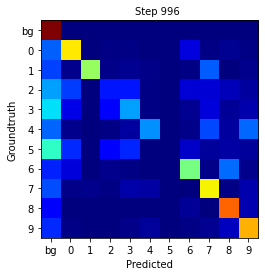

In [ ]:
meta_train(n_tasks = len(_tasks),
           epochs = 200,
           scenario = continual_mnist, 
           trainer=trainer,
           evaluater=evaluater,
           animation_path="pseudolabel_image_level")

In [ ]:
np.array(continual_mnist.train_data.curr_im_level_labels)

array([[1, 1, 1, ..., 0, 1, 0],
       [1, 0, 1, ..., 1, 0, 0],
       [1, 0, 1, ..., 0, 0, 0],
       ...,
       [1, 0, 1, ..., 1, 1, 0],
       [1, 0, 1, ..., 0, 0, 0],
       [1, 1, 0, ..., 1, 0, 0]])

In [ ]:
len(a)

72

#Experiments with Memory model

In [ ]:
from models.memory import memory

In [ ]:
from models import simple_seg_model
# Initialize dataloader, optimizer and trainer
_tasks = {0: [0,1], 1: [2,3], 2: [4,5], 3: [6,7], 4: [8,9]}
_offline = {0: list(np.arange(10))}

model = simple_seg_model(n_classes_per_task=[len(_tasks[0])+1])
model = model.cuda()
optimizer = torch.optim.Adam(lr = 0.0005, params=model.parameters())

#continual_mnist = ContinualMnist(n_train=1000, n_test=500, batch_size=72, tasks=_tasks)

evaluater = EvaluaterCallback(model, ["acc", "iou", "confusion_matrix"], callback_frequency="step", n_classes=11, save_matrices=True)

mem = memory(images_shape=(1,60,60),
             masks_shape=(60,60),
             n_classes = 2,
             batch_size=72,
             memory_size=1000)

trainer = Trainer(model,
                  n_classes=[3],
                  optim=optimizer,
                  callbacks=[evaluater])

In [ ]:
meta_train(n_tasks = len(_tasks),
           epochs = 200,
           scenario = continual_mnist, 
           trainer=trainer,
           evaluater=evaluater,
           memory=mem,
           animation_path="memory_100e_72b_72bm")

*******
Task #0
*******
Classes to learn:
-1 0 1
*******


100%|██████████| 200/200 [03:13<00:00,  1.04it/s]



Overall stats
|    |   Overall Acc |   Mean Acc |   Mean IoU |
|---:|--------------:|-----------:|-----------:|
|  0 |      0.894772 |   0.245599 |   0.212156 |
Class IoU
|    |      -1 |        0 |        1 |   2 |   3 |   4 |   5 |   6 |   7 |   8 |   9 |
|---:|--------:|---------:|---------:|----:|----:|----:|----:|----:|----:|----:|----:|
|  0 | 0.89533 | 0.731385 | 0.706998 |   0 |   0 |   0 |   0 |   0 |   0 |   0 |   0 |
Class Acc
|    |       -1 |        0 |        1 |   2 |   3 |   4 |   5 |   6 |   7 |   8 |   9 |
|---:|---------:|---------:|---------:|----:|----:|----:|----:|----:|----:|----:|----:|
|  0 | 0.998337 | 0.888966 | 0.814283 |   0 |   0 |   0 |   0 |   0 |   0 |   0 |   0 |

####################################
Next Task
####################################
*******
Task #1
*******
Classes to learn:
-1 2 3
*******


100%|██████████| 200/200 [03:48<00:00,  1.14s/it]



Overall stats
|    |   Overall Acc |   Mean Acc |   Mean IoU |
|---:|--------------:|-----------:|-----------:|
|  0 |      0.904283 |   0.294001 |   0.275561 |
Class IoU
|    |       -1 |        0 |        1 |        2 |        3 |   4 |   5 |   6 |   7 |   8 |   9 |
|---:|---------:|---------:|---------:|---------:|---------:|----:|----:|----:|----:|----:|----:|
|  0 | 0.903418 | 0.663515 | 0.547239 | 0.432992 | 0.484005 |   0 |   0 |   0 |   0 |   0 |   0 |
Class Acc
|    |       -1 |        0 |        1 |       2 |        3 |   4 |   5 |   6 |   7 |   8 |   9 |
|---:|---------:|---------:|---------:|--------:|---------:|----:|----:|----:|----:|----:|----:|
|  0 | 0.999185 | 0.686422 | 0.564824 | 0.46302 | 0.520563 |   0 |   0 |   0 |   0 |   0 |   0 |

####################################
Next Task
####################################
*******
Task #2
*******
Classes to learn:
-1 4 5
*******


100%|██████████| 200/200 [03:51<00:00,  1.16s/it]



Overall stats
|    |   Overall Acc |   Mean Acc |   Mean IoU |
|---:|--------------:|-----------:|-----------:|
|  0 |      0.903197 |   0.302314 |   0.270565 |
Class IoU
|    |      -1 |        0 |        1 |        2 |        3 |      4 |        5 |   6 |   7 |   8 |   9 |
|---:|--------:|---------:|---------:|---------:|---------:|-------:|---------:|----:|----:|----:|----:|
|  0 | 0.90572 | 0.410376 | 0.140271 | 0.276468 | 0.180908 | 0.5391 | 0.523378 |   0 |   0 |   0 |   0 |
Class Acc
|    |       -1 |        0 |        1 |        2 |        3 |       4 |        5 |   6 |   7 |   8 |   9 |
|---:|---------:|---------:|---------:|---------:|---------:|--------:|---------:|----:|----:|----:|----:|
|  0 | 0.998396 | 0.413438 | 0.140731 | 0.315535 | 0.192333 | 0.59892 | 0.666106 |   0 |   0 |   0 |   0 |

####################################
Next Task
####################################
*******
Task #3
*******
Classes to learn:
-1 6 7
*******


100%|██████████| 200/200 [03:58<00:00,  1.19s/it]



Overall stats
|    |   Overall Acc |   Mean Acc |   Mean IoU |
|---:|--------------:|-----------:|-----------:|
|  0 |       0.89475 |   0.226963 |   0.204347 |
Class IoU
|    |       -1 |         0 |         1 |          2 |         3 |           4 |         5 |        6 |        7 |   8 |   9 |
|---:|---------:|----------:|----------:|-----------:|----------:|------------:|----------:|---------:|---------:|----:|----:|
|  0 | 0.895059 | 0.0583491 | 0.0037377 | 0.00485458 | 0.0448504 | 0.000892061 | 0.0727346 | 0.617062 | 0.550281 |   0 |   0 |
Class Acc
|    |      -1 |         0 |          1 |          2 |         3 |           4 |         5 |        6 |        7 |   8 |   9 |
|---:|--------:|----------:|-----------:|-----------:|----------:|------------:|----------:|---------:|---------:|----:|----:|
|  0 | 0.99906 | 0.0584551 | 0.00373795 | 0.00486978 | 0.0449805 | 0.000892061 | 0.0740401 | 0.707892 | 0.602661 |   0 |   0 |

####################################
Next Task
########

100%|██████████| 200/200 [04:02<00:00,  1.21s/it]



Overall stats
|    |   Overall Acc |   Mean Acc |   Mean IoU |
|---:|--------------:|-----------:|-----------:|
|  0 |      0.889065 |   0.185208 |   0.167559 |
Class IoU
|    |       -1 |          0 |           1 |   2 |   3 |   4 |   5 |          6 |   7 |       8 |        9 |
|---:|---------:|-----------:|------------:|----:|----:|----:|----:|-----------:|----:|--------:|---------:|
|  0 | 0.889022 | 0.00339271 | 0.000131156 |   0 |   0 |   0 |   0 | 0.00116352 |   0 | 0.48455 | 0.464889 |
Class Acc
|    |       -1 |          0 |           1 |   2 |   3 |   4 |   5 |          6 |   7 |        8 |        9 |
|---:|---------:|-----------:|------------:|----:|----:|----:|----:|-----------:|----:|---------:|---------:|
|  0 | 0.999227 | 0.00340215 | 0.000131156 |   0 |   0 |   0 |   0 | 0.00116361 |   0 | 0.534506 | 0.498853 |

####################################
Next Task
####################################


## Intermediate-level + out distillation

In [ ]:
from trainer import Trainer_distillation
from models import simple_seg_model
_tasks = {0: [0,1], 1: [2,3], 2: [4,5], 3: [6,7], 4: [8,9]}
_offline = {0: list(np.arange(10))}

model = simple_seg_model(n_classes_per_task=[len(_tasks[0])+1])
model = model.cuda()
optimizer = torch.optim.Adam(lr = 0.0005, params=model.parameters())

continual_mnist = ContinualMnist(n_train=1000, n_test=500, batch_size=72, tasks=_tasks)

evaluater = EvaluaterCallback(model, ["acc", "iou", "confusion_matrix"], callback_frequency="step", n_classes=11, save_matrices=True)

trainer = Trainer_distillation(model,
                  n_classes=[3],
                  optim=optimizer,
                  from_new_class = 0,
                  lambda_distill=10,
                  output_level_distill=True,
                  encoder_level_distill=True,
                  callbacks=[evaluater])

In [ ]:
meta_train(n_tasks = len(_tasks),
           epochs = 200,
           scenario = continual_mnist, 
           trainer=trainer,
           evaluater=evaluater,
           animation_path="distillation_intermediate")

*******
Task #0
*******
Classes to learn:
-1 0 1
*******


100%|██████████| 200/200 [01:55<00:00,  1.73it/s]



Overall stats
|    |   Overall Acc |   Mean Acc |   Mean IoU |
|---:|--------------:|-----------:|-----------:|
|  0 |      0.988017 |   0.900923 |   0.841821 |
Class IoU
|    |       -1 |        0 |        1 | 2   | 3   | 4   | 5   | 6   | 7   | 8   | 9   |
|---:|---------:|---------:|---------:|:----|:----|:----|:----|:----|:----|:----|:----|
|  0 | 0.987756 | 0.785254 | 0.752453 | X   | X   | X   | X   | X   | X   | X   | X   |
Class Acc
|    |       -1 |        0 |       1 | 2   | 3   | 4   | 5   | 6   | 7   | 8   | 9   |
|---:|---------:|---------:|--------:|:----|:----|:----|:----|:----|:----|:----|:----|
|  0 | 0.994692 | 0.866687 | 0.84139 | X   | X   | X   | X   | X   | X   | X   | X   |

####################################
Next Task
####################################
*******
Task #1
*******
Classes to learn:
-1 2 3
*******


100%|██████████| 200/200 [02:53<00:00,  1.15it/s]



Overall stats
|    |   Overall Acc |   Mean Acc |   Mean IoU |
|---:|--------------:|-----------:|-----------:|
|  0 |      0.970977 |   0.877968 |   0.702618 |
Class IoU
|    |       -1 |        0 |        1 |        2 |        3 | 4   | 5   | 6   | 7   | 8   | 9   |
|---:|---------:|---------:|---------:|---------:|---------:|:----|:----|:----|:----|:----|:----|
|  0 | 0.973779 | 0.744079 | 0.611172 | 0.567803 | 0.616258 | X   | X   | X   | X   | X   | X   |
Class Acc
|    |       -1 |        0 |        1 |        2 |        3 | 4   | 5   | 6   | 7   | 8   | 9   |
|---:|---------:|---------:|---------:|---------:|---------:|:----|:----|:----|:----|:----|:----|
|  0 | 0.980218 | 0.922697 | 0.915696 | 0.772303 | 0.798925 | X   | X   | X   | X   | X   | X   |

####################################
Next Task
####################################
*******
Task #2
*******
Classes to learn:
-1 4 5
*******


100%|██████████| 200/200 [03:14<00:00,  1.03it/s]



Overall stats
|    |   Overall Acc |   Mean Acc |   Mean IoU |
|---:|--------------:|-----------:|-----------:|
|  0 |      0.935503 |   0.808642 |   0.519026 |
Class IoU
|    |       -1 |       0 |        1 |        2 |       3 |        4 |        5 | 6   | 7   | 8   | 9   |
|---:|---------:|--------:|---------:|---------:|--------:|---------:|---------:|:----|:----|:----|:----|
|  0 | 0.945914 | 0.62079 | 0.451053 | 0.422709 | 0.40278 | 0.436113 | 0.353825 | X   | X   | X   | X   |
Class Acc
|    |       -1 |        0 |        1 |        2 |        3 |        4 |        5 | 6   | 7   | 8   | 9   |
|---:|---------:|---------:|---------:|---------:|---------:|---------:|---------:|:----|:----|:----|:----|
|  0 | 0.949047 | 0.926183 | 0.887534 | 0.715054 | 0.736735 | 0.797086 | 0.648855 | X   | X   | X   | X   |

####################################
Next Task
####################################
*******
Task #3
*******
Classes to learn:
-1 6 7
*******


100%|██████████| 200/200 [03:28<00:00,  1.04s/it]



Overall stats
|    |   Overall Acc |   Mean Acc |   Mean IoU |
|---:|--------------:|-----------:|-----------:|
|  0 |       0.90356 |   0.760509 |    0.44988 |
Class IoU
|    |       -1 |       0 |        1 |        2 |        3 |        4 |        5 |        6 |        7 | 8   | 9   |
|---:|---------:|--------:|---------:|---------:|---------:|---------:|---------:|---------:|---------:|:----|:----|
|  0 | 0.920647 | 0.51977 | 0.366764 | 0.357445 | 0.296221 | 0.392499 | 0.301857 | 0.466215 | 0.427498 | X   | X   |
Class Acc
|    |       -1 |        0 |        1 |       2 |        3 |        4 |        5 |        6 |        7 | 8   | 9   |
|---:|---------:|---------:|---------:|--------:|---------:|---------:|---------:|---------:|---------:|:----|:----|
|  0 | 0.921527 | 0.908652 | 0.827248 | 0.65136 | 0.723426 | 0.652097 | 0.649786 | 0.767645 | 0.742845 | X   | X   |

####################################
Next Task
####################################
*******
Task #4
*******
Classes

100%|██████████| 200/200 [03:34<00:00,  1.07s/it]



Overall stats
|    |   Overall Acc |   Mean Acc |   Mean IoU |
|---:|--------------:|-----------:|-----------:|
|  0 |      0.872544 |   0.672709 |   0.384537 |
Class IoU
|    |       -1 |        0 |        1 |        2 |        3 |        4 |        5 |        6 |        7 |        8 |        9 |
|---:|---------:|---------:|---------:|---------:|---------:|---------:|---------:|---------:|---------:|---------:|---------:|
|  0 | 0.903896 | 0.404296 | 0.249562 | 0.311565 | 0.246773 | 0.368496 | 0.263955 | 0.433936 | 0.430866 | 0.282451 | 0.334106 |
Class Acc
|    |       -1 |        0 |        1 |        2 |       3 |        4 |        5 |        6 |        7 |        8 |        9 |
|---:|---------:|---------:|---------:|---------:|--------:|---------:|---------:|---------:|---------:|---------:|---------:|
|  0 | 0.904136 | 0.904821 | 0.843158 | 0.577177 | 0.57341 | 0.581793 | 0.545429 | 0.634699 | 0.680189 | 0.585898 | 0.569094 |

####################################
Next Task
#####

## Intermediate-level + decoder-level + output distillation

In [ ]:
from trainer import Trainer_distillation
from models import simple_seg_model
_tasks = {0: [0,1], 1: [2,3], 2: [4,5], 3: [6,7], 4: [8,9]}
_offline = {0: list(np.arange(10))}

model = simple_seg_model(n_classes_per_task=[len(_tasks[0])+1])
model = model.cuda()
optimizer = torch.optim.Adam(lr = 0.0005, params=model.parameters())

continual_mnist = ContinualMnist(n_train=1000, n_test=72*2, batch_size=72, tasks=_tasks)

evaluater = EvaluaterCallback(model, ["acc", "iou", "confusion_matrix"], callback_frequency="step", n_classes=11, save_matrices=True)

trainer = Trainer_distillation(model,
                  n_classes=[3],
                  optim=optimizer,
                  from_new_class = 0,
                  lambda_distill=1.25,
                  output_level_distill=True,
                  encoder_level_distill=False,
                  decoder_level_distill=True,
                  callbacks=[evaluater])

In [ ]:
meta_train(n_tasks = len(_tasks),
           epochs = 200,
           scenario = continual_mnist, 
           trainer=trainer,
           evaluater=evaluater,
           animation_path="distillation_encoder_decoder_output")

*******
Task #0
*******
Classes to learn:
-1 0 1
*******


100%|██████████| 200/200 [00:49<00:00,  4.01it/s]



Overall stats
|    |   Overall Acc |   Mean Acc |   Mean IoU |
|---:|--------------:|-----------:|-----------:|
|  0 |      0.985297 |   0.839015 |    0.80395 |
Class IoU
|    |      -1 |        0 |        1 | 2   | 3   | 4   | 5   | 6   | 7   | 8   | 9   |
|---:|--------:|---------:|---------:|:----|:----|:----|:----|:----|:----|:----|:----|
|  0 | 0.98483 | 0.704047 | 0.722973 | X   | X   | X   | X   | X   | X   | X   | X   |
Class Acc
|    |       -1 |        0 |        1 | 2   | 3   | 4   | 5   | 6   | 7   | 8   | 9   |
|---:|---------:|---------:|---------:|:----|:----|:----|:----|:----|:----|:----|:----|
|  0 | 0.996656 | 0.755472 | 0.764916 | X   | X   | X   | X   | X   | X   | X   | X   |

####################################
Next Task
####################################
*******
Task #1
*******
Classes to learn:
-1 2 3
*******


100%|██████████| 200/200 [01:30<00:00,  2.21it/s]



Overall stats
|    |   Overall Acc |   Mean Acc |   Mean IoU |
|---:|--------------:|-----------:|-----------:|
|  0 |      0.962843 |   0.578546 |   0.539237 |
Class IoU
|    |       -1 |        0 |        1 |        2 |       3 | 4   | 5   | 6   | 7   | 8   | 9   |
|---:|---------:|---------:|---------:|---------:|--------:|:----|:----|:----|:----|:----|:----|
|  0 | 0.963308 | 0.409522 | 0.335609 | 0.470765 | 0.51698 | X   | X   | X   | X   | X   | X   |
Class Acc
|    |       -1 |        0 |        1 |        2 |       3 | 4   | 5   | 6   | 7   | 8   | 9   |
|---:|---------:|---------:|---------:|---------:|--------:|:----|:----|:----|:----|:----|:----|
|  0 | 0.995584 | 0.419876 | 0.337916 | 0.530095 | 0.60926 | X   | X   | X   | X   | X   | X   |

####################################
Next Task
####################################
*******
Task #2
*******
Classes to learn:
-1 4 5
*******


100%|██████████| 200/200 [01:40<00:00,  1.99it/s]



Overall stats
|    |   Overall Acc |   Mean Acc |   Mean IoU |
|---:|--------------:|-----------:|-----------:|
|  0 |      0.938827 |   0.381739 |   0.301692 |
Class IoU
|    |       -1 |        0 |        1 |          2 |          3 |        4 |        5 | 6   | 7   | 8   | 9   |
|---:|---------:|---------:|---------:|-----------:|-----------:|---------:|---------:|:----|:----|:----|:----|
|  0 | 0.946514 | 0.126115 | 0.110989 | 0.00724871 | 0.00320602 | 0.532312 | 0.385459 | X   | X   | X   | X   |
Class Acc
|    |       -1 |        0 |        1 |          2 |          3 |        4 |        5 | 6   | 7   | 8   | 9   |
|---:|---------:|---------:|---------:|-----------:|-----------:|---------:|---------:|:----|:----|:----|:----|
|  0 | 0.994572 | 0.127473 | 0.111081 | 0.00726158 | 0.00320736 | 0.747604 | 0.680975 | X   | X   | X   | X   |

####################################
Next Task
####################################
*******
Task #3
*******
Classes to learn:
-1 6 7
*******


100%|██████████| 200/200 [02:00<00:00,  1.66it/s]



Overall stats
|    |   Overall Acc |   Mean Acc |   Mean IoU |
|---:|--------------:|-----------:|-----------:|
|  0 |       0.92779 |   0.389293 |   0.321474 |
Class IoU
|    |       -1 |        0 |         1 |   2 |   3 |        4 |        5 |        6 |        7 | 8   | 9   |
|---:|---------:|---------:|----------:|----:|----:|---------:|---------:|---------:|---------:|:----|:----|
|  0 | 0.935002 | 0.118656 | 0.0816383 |   0 |   0 | 0.316998 | 0.286344 | 0.631016 | 0.523607 | X   | X   |
Class Acc
|    |       -1 |        0 |         1 |   2 |   3 |        4 |        5 |        6 |        7 | 8   | 9   |
|---:|---------:|---------:|----------:|----:|----:|---------:|---------:|---------:|---------:|:----|:----|
|  0 | 0.994709 | 0.119045 | 0.0816607 |   0 |   0 | 0.336829 | 0.390513 | 0.800251 | 0.780633 | X   | X   |

####################################
Next Task
####################################
*******
Task #4
*******
Classes to learn:
-1 8 9
*******


100%|██████████| 200/200 [01:48<00:00,  1.84it/s]



Overall stats
|    |   Overall Acc |   Mean Acc |   Mean IoU |
|---:|--------------:|-----------:|-----------:|
|  0 |      0.899932 |   0.275167 |   0.234491 |
Class IoU
|    |       -1 |         0 |          1 |   2 |   3 |         4 |         5 |        6 |        7 |       8 |        9 |
|---:|---------:|----------:|-----------:|----:|----:|----------:|----------:|---------:|---------:|--------:|---------:|
|  0 | 0.902696 | 0.0161027 | 0.00219962 |   0 |   0 | 0.0027115 | 0.0148982 | 0.251196 | 0.245983 | 0.58952 | 0.554093 |
Class Acc
|    |       -1 |         0 |          1 |   2 |   3 |          4 |         5 |        6 |        7 |       8 |        9 |
|---:|---------:|----------:|-----------:|----:|----:|-----------:|----------:|---------:|---------:|--------:|---------:|
|  0 | 0.997193 | 0.0161536 | 0.00219962 |   0 |   0 | 0.00271199 | 0.0150326 | 0.257586 | 0.259404 | 0.74646 | 0.730091 |

####################################
Next Task
###################################